# Pulse wave classification in 7 classes（Undergraduate Design）
2022.4.10  author: Loki Xun

---
## 数据预处理
- 统一采样率
- 分片

## 时域：波形时序数据分类
- Bi-Lstm
- Transformer

## 频域：提取 MFCC、Fbank 特征
- 使用 CNN 分类

## 特征融合：Two-stream CNN 方式




In [ ]:
from google.colab import drive #挂载云端硬盘
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 将数据集存到分配到机器上

In [ ]:
!mkdir ./data_xrj
# !cp -r /content/drive/MyDrive/Pulse_7_Classification/seven_pulse2018/Fbank_666_840x280/ ./data_xrj
# !rm -rf /content/data_xrj/

In [ ]:
# 网盘文件压缩
def zip_directory(source_dir_path, target_zip_path):
    import zipfile
    import os
    from pathlib import Path

    assert os.path.exists(source_dir_path), f"source={source_dir_path} not exists!"
    with zipfile.ZipFile(target_zip_path, "a") as zipfp:
        for parent_dir, _, filename_list in os.walk(source_dir_path):
            for origin_filename in filename_list:
                origin_filepath_tmp = Path(parent_dir).joinpath(origin_filename)
                zipfp.write(origin_filepath_tmp.as_posix(),origin_filepath_tmp.name)
    print(f"source_dir_path={source_dir_path}, target_zip_path={target_zip_path} 压缩完成！")

In [ ]:
# 查看分配到的 GPU 资源是否为 P100
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sat May 28 16:00:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install python_speech_features
!pip install keras-flops

In [ ]:
import os
import re
from pathlib import Path
import random
from typing import Tuple, Union, Dict, List
import math
import time

import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import dct
from scipy.signal import spectrogram
from scipy.signal import resample_poly, butter, filtfilt, medfilt
from python_speech_features import mfcc, delta, fbank
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
# 显存设置
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# GPU 设置
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #保证程序中的GPU序号和硬件中的序号相同
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #设置 -1 使用 CPU 训练

# #  TensorFlow程序会默认占用显卡中的所有显存，设置按需求动态增长
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


pulse_class_name_list = ["滑脉", "平脉", "实脉", "细脉", "细弦脉", "弦滑脉", "弦脉"]  # 下标对应 class_no
base_path = Path("/content/drive/MyDrive/Pulse_7_Classification").resolve()
assert os.path.exists(base_path), "base_path loading failed!"
pulse_dataset_dir = base_path.joinpath("seven_pulse2018")
print(f"base_path={base_path}")
feature_result_dir = base_path.joinpath("feature_result")

base_path=/content/drive/MyDrive/Pulse_7_Classification


# 数据预处理
## data_preprocessing.py 数据预处理、频域特征提取

In [ ]:
class PulsePreprocessing:
    def __init__(self):
        self._test_num_each_class = 5

    @staticmethod
    def detrend_sigle_wave_data(wave_data_array, current_sample_rate=666) -> np.ndarray:
        """
        去除基线漂移: 基线漂移是一种低频噪声成分, 频率通常小于1Hz, 使用巴特沃斯高通过滤
        :param wave_data_array:
        :param current_sample_rate:
        :return:
        """
        assert len(wave_data_array.shape) == 2, f"wave_data_array shape={wave_data_array.shape} not match!"
        start_time = time.time()

        #  1. 0.5-50Hz 四阶巴特沃斯带通|过滤器
        LOW_CUT = 0.5
        HIGH_CUT = 100
        fn = 0.5 * current_sample_rate  # 最大频率
        f_low = LOW_CUT / fn
        f_high = HIGH_CUT / fn

        method_name = f"{LOW_CUT}Hz-{HIGH_CUT}Hz bandpass"
        freq_window = [f_low, f_high]
        b, a = butter(N=4, Wn=freq_window, btype="bandpass")
        filtered_signal = filtfilt(b, a, wave_data_array)
        # print(f"filtered_signal.shape={filtered_signal.shape}， filtered_signal={filtered_signal}")

        # # 2. 1Hz 巴特沃斯高通
        # method_name = f"{LOW_CUT}Hz HighPass"
        # freq_window = f_low
        # b, a = butter(N=4, Wn=freq_window, btype="highpass")
        # filtered_signal = filtfilt(b, a, wave_data_array)
        # # print(f"filtered_signal.shape={filtered_signal.shape}， filtered_signal={filtered_signal}")

        return filtered_signal

    @staticmethod
    def get_wave_peak_bottom_index(wave_data_array, current_sample_rate=666):
        # TODO: pip install biosppy
        assert len(wave_data_array.shape) == 2, f"shape not match"
        # peak_result = ecg.christov_segmenter(wave_data_array[0,], sampling_rate=current_sample_rate)
        # rpeaks_result = peak_result['rpeaks']
        # # get bottom
        # peak_result = ecg.christov_segmenter(wave_data_array[0,] * (-1), sampling_rate=current_sample_rate)
        # bottom_result = peak_result['rpeaks']
        # return rpeaks_result, bottom_result

    @staticmethod
    def copy_file_to_another_dir(source_path, save_path) -> Tuple[bool, str]:
        try:
            if not Path(source_path).is_file():
                raise Exception(f"原始文件不存在！source_path={source_path}")

            shutil.copy(source_path, save_path)
            return True, save_path

        except Exception as e:
            state_message = f"转移文件失败！message={str(e)}"
            logger.exception(state_message)
            return False, state_message

    @staticmethod
    def plot_wave_data(origin_pulse_array, downsampled_pulse_array, time_len: int):
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(origin_pulse_array, 'r-')
        plt.title(f"origin freq={origin_pulse_array.shape[0] / time_len} Hz")
        plt.subplot(2, 1, 2)
        plt.plot(downsampled_pulse_array, "b-")
        plt.title(f"downsample freq={downsampled_pulse_array.shape[0] / time_len} Hz")
        plt.grid(which="minor", linestyle='-.', axis='both')
        plt.show()

    @staticmethod
    def save_npy_file(pulse_data_dict, save_filename="train_test_data.npz"):
        save_path = pulse_dataset_dir.joinpath(save_filename).as_posix()
        np.savez(save_path, pulse_data=pulse_data_dict)
        print(f"保存npz 文件成功！save_path={save_path}")

    @staticmethod
    def load_npy_saved_pulse_data(npz_save_path: str) -> Dict[int, Dict[str, List[dict]]]:
        """
        load from npz file
            Pulse data description: In total 988 pulse samples, pulse's time info={'60.0s': 899, '6.0s': 89}: pulse data
           have 2 kinds of times info. And pulse data have sparse pressure info.
        :param npz_save_path:
        :return: pulse data dict-> Dict[ key=class->int, value=Dict[key in ('test','train'), value= signle_data_dict] ]
            single_data_dict=Dict['t':int, 'p':float, 'data':numpy array]
        """
        npz_result = np.load(npz_save_path, allow_pickle=True)
        pulse_all_class_data_dict = npz_result['pulse_data'].item()
        return pulse_all_class_data_dict

    @staticmethod
    def load_one_txt_data(data_filepath: str) -> Tuple[bool, Union[str, dict]]:
        """
        读取 txt 波形数据到 pandas.DataFrame
        :param data_filepath: 读取 txt 文件中数据
        :return: Dict[ 't': 秒数->float, 'p': 压力值->float, "data":时序波形数据->ndarray, 'filepath': str]
        """
        try:
            pulse_wave_data_list = []
            with open(data_filepath, "r+") as fp:
                for line_no, data_str in enumerate(fp.readlines()):
                    data_str = data_str.replace("\n", "")
                    if line_no == 0:
                        t_pulse, p_pulse = re.findall(r"\d+.\d*", data_str)[:2]
                    else:
                        pulse_wave_data_list.append(eval(data_str))

            return True, {"t": t_pulse, "p": p_pulse, "data": np.array([pulse_wave_data_list]),
                          'filepath': Path(data_filepath).name}
        except Exception as e:
            logger.exception(f"load_one_txt_data Failed! data_filepath={data_filepath}")
            return False, str(e)

    def split_origin_train_test_data(self) -> Tuple[bool, Union[dict, str]]:
        """
        分割 train、test 数据，存入字典，保存 npy 文件
        :return: data dict-> Dict[class_label, Dict[test:[], train:[]] ]
        """
        pulse_data_dict = {}
        for class_name in os.listdir(pulse_all_data_path.as_posix()):
            class_label = pulse_class_name_list.index(class_name)
            print(f"class={class_name}, class_label={class_label}")
            if class_name not in pulse_class_name_list:
                raise Exception(f"unsupported class type!class_name={class_name}")

            class_dir_path = pulse_all_data_path.joinpath(class_name)
            class_data_path_list = [class_dir_path.joinpath(item_filename).as_posix()
                                    for item_filename in os.listdir(class_dir_path.as_posix())]
            if not class_data_path_list:
                raise Exception(f"class={class_name} with empty data!")
            # 0. shuffle sequence
            random.seed(1)  # 设置随机种子，使得每次运行结果可复现
            random.shuffle(class_data_path_list)
            # 1. split train test
            test_filename_list = class_data_path_list[:self._test_num_each_class]
            train_filename_list = class_data_path_list[self._test_num_each_class:]

            # 2. extract data
            pulse_data_dict[class_label] = {"train": [], "test": []}
            for data_filepath in test_filename_list:
                success_flag, data_info_result = \
                    self.load_one_txt_data(data_filepath=data_filepath)
                if not success_flag:
                    raise Exception(data_info_result)
                pulse_data_dict[class_label]["test"].append(data_info_result)

            for data_filepath in train_filename_list:
                success_flag, data_info_result = \
                    self.load_one_txt_data(data_filepath=data_filepath)
                if not success_flag:
                    raise Exception(data_info_result)
                pulse_data_dict[class_label]["train"].append(data_info_result)

            logger.info(f"class={class_name}, label={class_label}: train_test_split success!"
                        f"train_num={len(train_filename_list)}, test_num={len(test_filename_list)}")
        # save npy file
        self.save_npy_file(pulse_data_dict)
        print(f"train_test_split finish!")
        return True, pulse_data_dict

    @staticmethod
    def downsample_pulse_data(wave_data_array, origin_time_length, target_sample_rate):
        """对数据进行重采样"""
        assert isinstance(wave_data_array, np.ndarray) and len(wave_data_array.shape) == 2
        # 1. 均匀采样
        time_index_list = np.linspace(start=0, stop=wave_data_array.shape[1],
                                      num=math.ceil(origin_time_length * target_sample_rate), endpoint=False, dtype=int)
        # downsampled_data = wave_data_array[:, time_index_list]
        # print(f"shape={wave_data_array.shape},wave_data_list={wave_data_array}")
        # print(f"shape={wave_data_array.shape}, time_index_list={time_index_list}")
        # print(f"shape={downsampled_data.shape}, downsampled_data={downsampled_data}, type={type(downsampled_data)}")

        # 1.2 np.interp
        downsampled_data = np.interp(time_index_list, np.arange(0, wave_data_array.shape[1]), wave_data_array[0])
        downsampled_data = downsampled_data.reshape((1, downsampled_data.shape[0]))
        print(f"wave_data_list={wave_data_array}, shape={wave_data_array.shape}")
        print(f"downsampled_data={downsampled_data}, shape={downsampled_data.shape}")

        # # 2. scipy signal
        # current_sample_rate = int(wave_data_array.shape[1] / origin_time_length)
        # downsampled_data = resample_poly(wave_data_array[0, :], up=target_sample_rate, down=current_sample_rate)
        # downsampled_data = downsampled_data.reshape((1, downsampled_data.shape[0]))
        # print(f"shape={wave_data_array.shape},wave_data_list={wave_data_array}")
        # print(f"shape={downsampled_data.shape}, downsampled_data={downsampled_data}, type={type(downsampled_data)}")

        return downsampled_data

    def unify_sample_rate(self, pulse_all_class_data_dict, target_sample_rate=666):
        """
        统一sample rate, 全部降采样到 666 Hz （采样率的最小值）
        :param pulse_all_class_data_dict:
        :param target_sample_rate:
        :return:
        """
        for class_no in pulse_all_class_data_dict:
            for type_str in ["train", "test"]:
                for data_index in range(len(pulse_all_class_data_dict[class_no][type_str])):
                    data_info_dict = pulse_all_class_data_dict[class_no][type_str][data_index]
                    wave_data_array = data_info_dict['data']
                    down_sample_data = self.downsample_pulse_data(wave_data_array=data_info_dict["data"],
                                                                  origin_time_length=eval(data_info_dict['t']),
                                                                  target_sample_rate=target_sample_rate)
                    pulse_all_class_data_dict[class_no][type_str][data_index]["data"] = down_sample_data
                    # self.plot_wave_data(wave_data_array[0,], down_sample_data[0,], time_len=eval(data_info_dict['t']))

            print(f"class_no={class_no} 降采样完成！")
        return pulse_all_class_data_dict

    @staticmethod
    def get_train_test_data_slice(pulse_all_data_dict, frame_length=600, frame_step=350):
        """
        对原始时序数据按 步长、帧移 分片，获取模型输入 x_train, y_train
        :param pulse_all_data_dict: Dict[class_no->int, key=Dict[key in ('train','test'), value=List[data_info_dict]] ]
            data_info_dict -> Dict['t'->str, 'p'->str, 'data'->np.ndarray(shape=(1,n))]
        :param frame_length:
        :param frame_step:
        :return: x_train->np.ndarray , shape= (n, frame_length), y_train->np.ndarray, shape=(n,1)
        """
        train_data_dict = {"x_train": [], "y_train": [], "x_test": [], "y_test": []}
        # 帧移调整参数，提前求出
        class_frame_step_dict = {6: int(frame_step/0.36), 5: int(frame_step/0.81), 4: int(frame_step/1.2),
                                 3: int(frame_step / 5), 2: int(frame_step / 3), 1: int(frame_step / 4), 0: int(frame_step / 1.7)}
        # class_frame_step_dict = {6: frame_step, 5: frame_step, 4: frame_step,
        #                          3: frame_step, 2: frame_step, 1: frame_step, 0: frame_step}
        origin_frame_step=frame_step
        for class_no in pulse_all_data_dict:
            for data_type_str in ["train", "test"]:
                # 少数类,增加分片数, 多数类减少分片数
                frame_step = class_frame_step_dict[class_no] if data_type_str=="train" else origin_frame_step

                for data_info_dict in pulse_all_data_dict[class_no][data_type_str]:
                    # 分片
                    wave_data_array = data_info_dict["data"][0,]  # 原始 shape=(1,n)
                    signal_length = len(wave_data_array)
                    num_frames = int(
                        np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
                    pad_signal_length = (num_frames - 1) * frame_step + frame_length
                    z = np.zeros((pad_signal_length - signal_length))
                    # 分帧后最后一帧点数不足，则补零
                    # 获取帧：frames 是二维数组，每一行是一帧，列数是每帧的采样点数，之后的短时 fft 直接在每一列上操作
                    pad_signal = np.append(wave_data_array, z)
                    indices = np.arange(0, frame_length).reshape(
                        1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
                    frames = pad_signal[indices]

                    # add to x_train, y_train
                    train_data_dict[f"x_{data_type_str}"].extend(frames.tolist())
                    train_data_dict[f"y_{data_type_str}"].extend([int(class_no)] * frames.shape[0])

                print(f"class_no={class_no}, data_type_str={data_type_str} 分片完成！")

        x_train = np.array(train_data_dict["x_train"])
        y_train = np.array(train_data_dict["y_train"]).reshape((-1, 1))
        x_test = np.array(train_data_dict["x_test"])
        y_test = np.array(train_data_dict["y_test"]).reshape((-1, 1))

        print(f"x_train shape={x_train.shape}")
        print(f"y_train shape={y_train.shape}")
        print(f"x_test shape={x_test.shape}")
        print(f"y_test shape={y_test.shape}")

        return x_train, y_train, x_test, y_test

    def detrend_wave_data(self, pulse_all_data_dict):
        for class_no in pulse_all_data_dict:
            for type_str in ["train", "test"]:
                for data_index in range(len(pulse_all_data_dict[class_no][type_str])):
                    data_info_dict = pulse_all_data_dict[class_no][type_str][data_index]
                    current_sample_rate = int(data_info_dict["data"].shape[1] / eval(data_info_dict['t']))
                    detrend_wave_data = self.detrend_sigle_wave_data(data_info_dict["data"],
                                                                     current_sample_rate=current_sample_rate)
                    pulse_all_data_dict[class_no][type_str][data_index]["data"] = detrend_wave_data

            print(f"class_no={class_no} 去基线漂移完成！")
        return pulse_all_data_dict

    
class PulseFeature:
    def __init__(self):
        pass

    @staticmethod
    def standardize_wave_data(wave_data):
        wave_mean = np.mean(wave_data, axis=1)
        wave_std = np.std(wave_data, axis=1)
        return (wave_data - wave_mean) / wave_std

    @staticmethod
    def plot_spectrogram(spec, save_path):
        fig = plt.figure(figsize=(20, 5))
        heatmap = plt.pcolor(spec)
        fig.colorbar(mappable=heatmap)
        plt.xlabel('Frames')
        # tight_layout 会自动调整子图参数，使之填充整个图像区域
        # plt.tight_layout()
        plt.title(save_path.stem)
        plt.savefig(save_path)
        plt.show()

    @staticmethod
    def get_scipy_spectrogram(wave_data, sample_rate, frame_size=0.025, frame_stride=0.01, filename=""):
        freq_array, time_segment, Spectrogram_x = spectrogram(x=wave_data[0, :], fs=sample_rate)
        plt.figure(1)
        plt.pcolormesh(time_segment, freq_array, Spectrogram_x, shading="gouraud")
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

    @staticmethod
    def get_frames(wave_data, sample_rate, frame_size=0.025, frame_stride=0.01):
        """
        预加重, 分帧, 幅值归一化
        :param wave_data: ndarray, shape=(1,n)
        :param sample_rate: 采样率
        :param frame_size: 帧长 默认 25 ms
        :param frame_stride: 帧移 默认 10 ms
        :return:
        """
        # 1. 预加重: 补偿高频部分振幅
        pre_emphasis = 0.97
        emphasized_signal = np.append(
            wave_data[0, 0], wave_data[:, 1:] - pre_emphasis * wave_data[:, -1])

        # 2. 分帧
        frame_length, frame_step = int(
            round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))
        signal_length = len(emphasized_signal)
        num_frames = int(
            np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
        pad_signal_length = (num_frames - 1) * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        # 分帧后最后一帧点数不足，则补零
        # 获取帧：frames 是二维数组，每一行是一帧，列数是每帧的采样点数，之后的短时 fft 直接在每一列上操作
        pad_signal = np.append(emphasized_signal, z)
        indices = np.arange(0, frame_length).reshape(
            1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
        frames = pad_signal[indices]
        print("shape of frames:", frames.shape)

        # 3. 加 hamming 窗
        frames *= np.hamming(frame_length)
        return frames

    def save_fbank_mfcc_feature(self, wave_data, sample_rate, frame_size=0.025, frame_stride=0.01, save_name=""):
        """
        提取 Fbank、MFCC 特征: 自己编写的
        :param wave_data:
        :param sample_rate:
        :param frame_size:
        :param frame_stride:
        :param save_name:
        :return:
        """
        # 分帧, 加窗
        frames = self.get_frames(wave_data=wave_data, sample_rate=sample_rate,
                                 frame_size=frame_size, frame_stride=frame_stride)
        print(f"frames shape={frames.shape}, {frames}")
        # FFT
        NFFT = 512  # 频谱系数的点数
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # 频谱幅值
        pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))  # 能量频谱
        print(f"FFT result: pow_frames shape={pow_frames.shape}, pow_frames={pow_frames}")

        # Fbank
        low_freq_mel = 0
        high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
        # mel 滤波器中心点：为了方便后面计算 mel 滤波器组，左右两边各补一个中心点
        nfilt = 200  # Mel 滤波器个数
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

        hz_points = 700 * (10 ** (mel_points / 2595) - 1)
        fbank = np.zeros((nfilt, int(NFFT / 2 + 1)))  # 各个 mel 滤波器在能量谱对应点的取值
        bin = (hz_points / (sample_rate / 2)) * \
              (NFFT / 2)  # 各个 mel 滤波器中心点对应 FFT 的区域编码，找到有值的位置
        # 计算 mel 滤波器函数: 矩阵运算更快
        for i in range(1, nfilt + 1):
            left = int(bin[i - 1])
            center = int(bin[i])
            right = int(bin[i + 1])
            for j in range(left, center):
                fbank[i - 1, j + 1] = (j + 1 - bin[i - 1]) / (bin[i] - bin[i - 1])
            for j in range(center, right):
                fbank[i - 1, j + 1] = (bin[i + 1] - (j + 1)) / (bin[i + 1] - bin[i])
                # print(fbank)
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
        filter_banks = 20 * np.log10(filter_banks)  # dB
        # print(filter_banks)
        print("shape of FBank", filter_banks.shape)
        print(f"filter_banks={filter_banks}")
        self.plot_spectrogram(filter_banks.T, feature_result_dir.joinpath(f"Fbank_{save_name}"))

        # MFCC
        num_ceps = 12  # 保留的倒谱系数的个数
        mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')  # shape of MFCC=(570 帧数, 200 滤波器个数)
        mfcc_feature_result = mfcc[:, 1:(num_ceps + 1)]  # 选取 2-13 维度
        print(f"shape of MFCC={mfcc.shape}, mfcc={mfcc}")
        self.plot_spectrogram(mfcc_feature_result.T, feature_result_dir.joinpath(f"MFCC_{save_name}"))

        # Normalization
        filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
        self.plot_spectrogram(filter_banks.T, feature_result_dir.joinpath(f"Fbank_normalized_{save_name}"))
        mfcc_feature_result -= (np.mean(mfcc_feature_result, axis=0) + 1e-8)
        self.plot_spectrogram(mfcc_feature_result.T, feature_result_dir.joinpath(f"MFCC_normalized_{save_name}"))

    @staticmethod
    def get_dynamic_mfcc_matrix(wave_data, sample_rate, mfcc_normalization=False,
                                winlen=0.025, winstep=0.01, numcep=13, nfilt=200, winfunc=np.hamming):
        """
        第三方开源模块 python_speech_features, 提取 动态 mfcc 特征： 静态+一、二阶差分
        :param wave_data:
        :param sample_rate:
        :param mfcc_normalization:
        :param winlen:
        :param winstep:
        :param numcep:
        :param nfilt:
        :param winfunc:
        :return:
        """
        assert isinstance(wave_data, np.ndarray) and len(wave_data.shape) == 2, f"wave_data 格式错误！"

        mfcc_feature_result = mfcc(signal=wave_data.T, samplerate=sample_rate, winlen=winlen, winstep=winstep,
                                   numcep=numcep, nfilt=nfilt, winfunc=winfunc)
        # print(f"mfcc: static feature result={mfcc_feature_result.shape}, {mfcc_feature_result}")

        # 动态特征：计算一阶、二阶差分, 对每个特征向量进行延长（1*13-> 1*39)
        d_mfcc_feat = delta(mfcc_feature_result, 1)  # 每行为一个特征向量
        d_mfcc_feat2 = delta(mfcc_feature_result, 2)
        mfcc_final_result = np.hstack((mfcc_feature_result, d_mfcc_feat, d_mfcc_feat2))

        # MFCC, Fbank features: normalization
        if mfcc_normalization:
            mfcc_final_result -= (np.mean(mfcc_final_result, axis=0) + 1e-8)

        return mfcc_final_result

    @staticmethod
    def get_fbank_matrix(wave_data, sample_rate, winlen=0.025, winstep=0.01, nfilt=200, winfunc=np.hamming):
        """
        第三方开源模块 python_speech_features, 提取 fbank 特征
        :param wave_data:
        :param sample_rate:
        :param winlen:
        :param winstep:
        :param nfilt:
        :param winfunc:
        :return:
        """
        assert isinstance(wave_data, np.ndarray) and len(wave_data.shape) == 2, f"wave_data 格式错误！"

        fbank_result, energy_each_frame = fbank(signal=wave_data.T, samplerate=sample_rate, winlen=winlen,
                                                winstep=winstep,
                                                nfilt=nfilt, winfunc=winfunc)  # 未取对数
        return np.log(fbank_result)

    def get_train_test_data_mfcc_feature(self, x_data, sample_rate=666.0, numcep=20):
        """
        每片序列数据转换为 mfcc 或 fbank 矩阵
        :param x_data:
        :param get_dynamic_mfcc_matrix_func:
        :param sample_rate:
        :param numcep:
        :return:
        """
        assert isinstance(x_data, np.ndarray) and len(x_data.shape) == 2

        mfcc_feature_data = []
        for data_index in range(x_data.shape[0]):
            wave_data_array = np.reshape(x_data[data_index, :], (1, -1))
            freq_feature_result = self.get_dynamic_mfcc_matrix(wave_data=wave_data_array, sample_rate=sample_rate,
                                                               numcep=numcep)
            mfcc_feature_data.append(freq_feature_result)

        mfcc_feature_data = np.array(mfcc_feature_data, dtype=np.float32)
        return mfcc_feature_data

    def get_train_test_data_fbank_feature(self, x_data, sample_rate=666.0):
        """
        每片序列数据转换为 mfcc 或 fbank 矩阵
        :param x_data:
        :param sample_rate:
        :return:
        """
        assert isinstance(x_data, np.ndarray) and len(x_data.shape) == 2

        fbank_feature_data = []
        for data_index in range(x_data.shape[0]):
            wave_data_array = np.reshape(x_data[data_index, :], (1, -1))
            freq_feature_result = self.get_fbank_matrix(wave_data=wave_data_array, sample_rate=sample_rate)
            fbank_feature_data.append(freq_feature_result)
            if int(data_index // x_data.shape[0]) > 0 and int(data_index % 20) == 0:
                print(f"fbank 特征转换: No.{data_index}/{x_data.shape[0]}")

        fbank_feature_data = np.array(fbank_feature_data, dtype=np.float16)
        return fbank_feature_data
    
    def convert_save_fbank_feature(self, x_data, y_data, fbank_save_dir_path: str,
                                   sample_rate=666.0, filename_prefix="x_train") \
            -> Tuple[bool, list]:
        """
        每片序列数据转换为 fbank 矩阵 , 单独存储为 npy 文件
        :param x_data:
        :param y_data
        :param fbank_save_dir_path
        :param sample_rate:
        :param filename_prefix:
        :return: 返回文件路径列表
        """
        assert isinstance(x_data, np.ndarray) and len(x_data.shape) == 2
        assert x_data.shape[0] == y_data.shape[0]
        fbank_save_dir_path = Path(fbank_save_dir_path)
        assert fbank_save_dir_path.exists(), f"Fbank 保存路径不存在！{fbank_save_dir_path}"

        start_time = time.time()
        fbank_data_path_list = []
        for data_index in range(x_data.shape[0]):
            wave_data_array = np.reshape(x_data[data_index, :], (1, -1))
            freq_feature_result = self.get_fbank_matrix(wave_data=wave_data_array, sample_rate=sample_rate)
            # save npy file
            fbank_save_name = f"{filename_prefix}_{data_index}_{int(y_data[data_index, 0])}"
            fbank_save_path = fbank_save_dir_path.joinpath(fbank_save_name).as_posix()
            np.save(fbank_save_path, freq_feature_result)
            fbank_data_path_list.append(fbank_save_path)

            if data_index % 3000 == 0:
                print(f"{filename_prefix} 存储 Fbank 特征：No.{data_index}/{x_data.shape[0]} costs={int(time.time()-start_time)/60}min")

        return True, fbank_data_path_list

# 读取数据

## 数据分片
- 根据指定帧长、帧移, 分片
- x_train, x_test 转换为 MFCC, Fbank 矩阵

In [ ]:
# 读取数据信息
import math
import time
pulse_preprocess = PulsePreprocessing()
downsampled_npz_filename = "downsampled_train_test_dict.npz"
sample_rate = 666.0  # 统一的采样率
npz_save_path_str = pulse_dataset_dir.joinpath(downsampled_npz_filename).as_posix()
assert Path(npz_save_path_str).is_file(), f"文件不存在, filepath={npz_save_path_str}"
pulse_all_class_data_dict = pulse_preprocess.load_npy_saved_pulse_data(npz_save_path=npz_save_path_str)

# 去基线漂移+去噪
start_time=time.time()
pulse_all_class_data_dict = pulse_preprocess.detrend_wave_data(pulse_all_class_data_dict)
print(f"去噪+去基线漂移完成！costs={time.time()-start_time}s")

# 切片
start_time = time.time()
heart_beat_average_seconds = 1.2 # 按平均一次心跳的秒数分片
frame_length = math.ceil(heart_beat_average_seconds * sample_rate)+40  # 840
frame_step = 280  # int(frame_length/3)
# frame_length = math.ceil(heart_beat_average_seconds * sample_rate)*3  # 2400
# frame_step = 350  # int(frame_length/3)

x_train, y_train, x_test, y_test = PulsePreprocessing.get_train_test_data_slice(
    pulse_all_class_data_dict,frame_length=frame_length,frame_step=frame_step)
print(f"get data slices costs={time.time() - start_time}s")  # 9s

In [ ]:
# # 计算需要 20000 个分片，每个类需要多大帧移
# needed_clips_num = 20000
# frame_strp_dict={}
# for class_no in pulse_all_class_data_dict:
#   data_len_list=[item["data"].shape[1] for item in pulse_all_class_data_dict[class_no]["train"]]
#   proper_frame_step = (sum(data_len_list) - frame_length * len(data_len_list))/(needed_clips_num-len(data_len_list))
#   frame_strp_dict[class_no]=proper_frame_step
# print(frame_strp_dict)


In [ ]:
# 检查每一类分片数
# 原始脉诊样本
class_data_info_dict={class_no:(len(pulse_all_class_data_dict[class_no]["train"]),len(pulse_all_class_data_dict[class_no]["test"])) for class_no in pulse_all_class_data_dict}
print(class_data_info_dict)

# train、test、validate 中的各类分布
train_distribution_dict={class_no:np.sum(y_train==class_no) for class_no in class_data_info_dict}
print(f"y_train distribution:{train_distribution_dict}")
train_distribution_dict={class_no:np.sum(y_test==class_no) for class_no in class_data_info_dict}
print(f"y_test distribution:{train_distribution_dict}")

{2: (54, 5), 1: (39, 5), 5: (188, 5), 6: (435, 5), 0: (92, 5), 4: (117, 5), 3: (28, 5)}
y_train distribution:{2: 16930, 1: 14822, 5: 15382, 6: 15291, 0: 15436, 4: 15203, 3: 15064}
y_test distribution:{2: 545, 1: 545, 5: 442, 6: 545, 0: 545, 4: 545, 3: 545}


In [ ]:
# 查看分片长度是否合适
def show_slice_effect(x_array, y_array, show_num=50):
    """检查分片长度是否合适"""
    show_num = min(show_num, x_array.shape[0])
    columns_num = 5
    ros_num = int(show_num / columns_num)
    plt.figure(figsize=(15, 5 * ros_num))
    for i in range(show_num):
        plt.subplot(ros_num, columns_num, i + 1)
        plt.plot(x_array[i, :])
        plt.title(f"class={y_array[i,]}")
    plt.show()
show_slice_effect(x_test[3000:,], y_test[3000:,])

## 频域分类：转换为 MFCC、Fbank 特征，使用 CNN 网络分类
- 训练数据预处理

In [ ]:
# # 转换为 MFCC、Fbank 特征
# pulse_feature = PulseFeature()
# # 1. 获取 MFCC 特征
# start_time = time.time()
# x_train = pulse_feature.get_train_test_data_mfcc_feature(x_data=x_train,
#                                                                       sample_rate=sample_rate, numcep=20)
# print(f"mfcc_feature_x_train: mfcc 特征转换成功！costs={(time.time() - start_time)/60}min")
# x_test = pulse_feature.get_train_test_data_mfcc_feature(x_data=x_test,
#                                                                      sample_rate=sample_rate, numcep=20)
# print(f"mfcc_feature_x_train shape={x_train.shape}, "
#       f"mfcc_feature_x_test shape={x_test.shape}, costs={(time.time() - start_time)/60}min")
# mfcc_pulse_data_dict = {"x_train": x_train, "y_train": y_train,
#                         "x_test": x_test, "y_test": y_test}
# mfcc_pulse_data_npz_filename = f"MFCC_{sample_rate}_{frame_length}x{frame_step}_05-50_detrend_balance-1.npz"
# # 保存 npz 文件
# pulse_preprocess.save_npy_file(pulse_data_dict=mfcc_pulse_data_dict, save_filename=mfcc_pulse_data_npz_filename)
# del mfcc_pulse_data_dict

# # -------读取 MFCC 保存的数据(读取的每个 mfcc shape=119x60) 要加一维！
# mfcc_pulse_data_npz_filename = "MFCC_666.0_840x280.npz"  # "MFCC_666.0_840x280_detrend_balance-1.npz"
# data_save_path = pulse_dataset_dir.joinpath(mfcc_pulse_data_npz_filename).as_posix()
# mfcc_pulse_data_dict = PulsePreprocessing.load_npy_saved_pulse_data(data_save_path)
# x_train, y_train, x_test, y_test = mfcc_pulse_data_dict["x_train"], mfcc_pulse_data_dict["y_train"], \
#                                    mfcc_pulse_data_dict["x_test"], mfcc_pulse_data_dict["y_test"]
# del mfcc_pulse_data_dict
# x_train = np.reshape(x_train, (*x_train.shape, 1))  # 增加一维
# x_test = np.reshape(x_test, (*x_test.shape, 1))


# # 2. 获取 Fbank 特征
pulse_feature = PulseFeature()
start_time = time.time()
# 2.0 每个分片转化为 Fbank 直接保存到本地
fbank_data_name = f"Fbank_{int(sample_rate)}_{frame_length}x{frame_step}"
# fbank_save_dir = pulse_dataset_dir.joinpath(fbank_data_name)
fbank_save_dir = Path("./data_xrj").resolve().joinpath(fbank_data_name)
fbank_save_dir.mkdir(exist_ok=True, parents=True)
print(f"fbank_save_dir={fbank_save_dir} 提取 fbank 特征并存储")


_, x_train_path_list = pulse_feature.convert_save_fbank_feature(x_train, y_train,
                                 fbank_save_dir_path=fbank_save_dir,
                                 sample_rate=sample_rate,
                                 filename_prefix="train"
                                 )
print(f"fbank_feature_x_train: fbank 特征转换成功！costs={time.time() - start_time}s")
_, x_test_path_list = pulse_feature.convert_save_fbank_feature(x_test, y_test,
                                 fbank_save_dir_path=fbank_save_dir,
                                 sample_rate=sample_rate,
                                 filename_prefix="test"
                                 )
print(f"fbank_feature_x_test: fbank 特征转换成功！total costs={time.time() - start_time}s")
fbank_pulse_data_dict = {"x_train_path_list": x_train_path_list, "y_train": y_train,
                          "x_test_path_list": x_test_path_list, "y_test": y_test}
pulse_preprocess.save_npy_file(pulse_data_dict=fbank_pulse_data_dict, save_filename=f"{fbank_data_name}_pathlist")
del fbank_pulse_data_dict
x_train = x_train_path_list
x_test = x_test_path_list


# # 2.1 x_test 直接转化 Fbank 存入内存，用于测试
# x_test = pulse_feature.get_train_test_data_fbank_feature(x_data=x_test, sample_rate=sample_rate)
# x_test = np.reshape(x_test, (*x_test.shape, 1))
# print(f"x_test shape={x_test.shape}")

# # 读取 Fbank 保存的数据 （保存的是npy文件路径列表，之后需要加通道！）
# fbank_pulse_data_npz_filename = "Fbank_666_840x280_pathlist.npz"
# data_save_path = pulse_dataset_dir.joinpath(fbank_pulse_data_npz_filename).as_posix()
# fbank_data_name = f"Fbank_666_840x280"
# fbank_save_dir =  Path("./data_xrj").resolve().joinpath(fbank_data_name)

# fbank_pulse_data_dict = PulsePreprocessing.load_npy_saved_pulse_data(data_save_path)
# x_train, y_train, x_test, y_test = fbank_pulse_data_dict["x_train_path_list"], fbank_pulse_data_dict["y_train"], \
#                                    fbank_pulse_data_dict["x_test_path_list"], fbank_pulse_data_dict["y_test"]
# del fbank_pulse_data_dict

x_train = np.array([x_train]).T
x_test = np.array([x_test]).T


# 打乱数据集
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

fbank_save_dir=/content/data_xrj/Fbank_666_2400x350 提取 fbank 特征并存储
train 存储 Fbank 特征：No.0/108128 costs=0.0min
train 存储 Fbank 特征：No.3000/108128 costs=0.48333333333333334min
train 存储 Fbank 特征：No.6000/108128 costs=1.0min
train 存储 Fbank 特征：No.9000/108128 costs=1.5min
train 存储 Fbank 特征：No.12000/108128 costs=2.0min
train 存储 Fbank 特征：No.15000/108128 costs=2.5166666666666666min
train 存储 Fbank 特征：No.18000/108128 costs=3.033333333333333min
train 存储 Fbank 特征：No.21000/108128 costs=3.533333333333333min
train 存储 Fbank 特征：No.24000/108128 costs=4.05min
train 存储 Fbank 特征：No.27000/108128 costs=4.55min
train 存储 Fbank 特征：No.30000/108128 costs=5.066666666666666min
train 存储 Fbank 特征：No.33000/108128 costs=5.566666666666666min
train 存储 Fbank 特征：No.36000/108128 costs=6.083333333333333min
train 存储 Fbank 特征：No.39000/108128 costs=6.583333333333333min
train 存储 Fbank 特征：No.42000/108128 costs=7.116666666666666min
train 存储 Fbank 特征：No.45000/108128 costs=7.616666666666666min
train 存储 Fbank 特征：No.48000/108128 costs=8.1

In [ ]:
# 分割 train、validation set
# assert len(x_train.shape)==4, f"x_train shape={x_train.shape} 没有增加一维！"
print(f"origin x_train.shape={x_train.shape}, y_train.shape={y_train.shape}")

train_num = int(x_train.shape[0]*0.9)
x_validate = x_train[train_num:,:]
y_validate = y_train[train_num:,:]
x_train = x_train[0:train_num,:]
y_train = y_train[0:train_num,:]


print(f"split after: x_train.shape={x_train.shape}, y_train.shape={y_train.shape}, train_num={train_num}")
print(f"split after: x_validate.shape={x_validate.shape}, y_validate.shape={y_validate.shape}")

print(y_train[:10])  # 检查是否已经打乱

origin x_train.shape=(108128, 1), y_train.shape=(108128, 1)
split after: x_train.shape=(97315, 1), y_train.shape=(97315, 1), train_num=97315
split after: x_validate.shape=(10813, 1), y_validate.shape=(10813, 1)
[[5]
 [3]
 [3]
 [2]
 [3]
 [1]
 [6]
 [3]
 [0]
 [3]]


In [ ]:
print(f"x_train.shape={x_train.shape}, y_train.shape={y_train.shape},x_validate.shape={x_validate.shape}, y_validate.shape={y_validate.shape}")

x_train.shape=(97315, 1), y_train.shape=(97315, 1),x_validate.shape=(10813, 1), y_validate.shape=(10813, 1)


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_path_array, y_data_array, batch_size=64, shuffle=True, feature_save_dir_path=""):
        self.x_path_array = x_path_array  # npy 文件路径 array
        self.y_data_array = y_data_array
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.index_array = np.arange(len(self.x_path_array))
        self.feature_save_dir = Path(feature_save_dir_path)
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x_path_array) / self.batch_size)

    def __getitem__(self, idx):
        # Generate indexes of the batch
        indexes = self.index_array[idx * self.batch_size: (idx + 1) * self.batch_size]
        # Find list of IDs
        y_data_return = self.y_data_array[indexes, :]
        x_path_list_temp = [self.x_path_array[k, :] for k in indexes]  # 取出一部分数据
        x_data_return = self.__load_batch_x_data_from_file(x_path_list_temp)
        if len(x_data_return.shape)!=4:
          x_data_return = np.reshape(x_data_return, (*x_data_return.shape, 1))
        # print(f"x_data_return shape={x_data_return.shape}")
        return x_data_return, y_data_return

    def on_epoch_end(self):
        self.index_array = np.arange(len(self.x_path_array))
        if self.shuffle:
            np.random.shuffle(self.index_array)

    def __load_batch_x_data_from_file(self, x_path_list) -> np.ndarray:
        """读取本地文件，生成 batch data（ndarray）"""
        x_return_array = []
        for idx in range(len(x_path_list)):
          npy_name = Path(x_path_list[idx][0]).name  # avoid saved as absolute path
          x_data_save_path = self.feature_save_dir.joinpath(f"{npy_name}.npy").as_posix()
          x_data = np.load(x_data_save_path)
          x_return_array.append(x_data)

        return np.array(x_return_array)



## CBAM 模块

In [ ]:
import keras.backend as K
import keras.layers as KL
from tensorflow.keras.layers import Reshape

# 判断输入数据格式，是channels_first还是channels_last
channel_axis = 1  if K.image_data_format() == "channels_first" else 3

# CAM
def channel_attention(input_xs, reduction_ratio=0.125):
    # get channel
    channel = int(input_xs.shape[channel_axis])
    maxpool_channel = KL.GlobalMaxPooling2D()(input_xs)
    maxpool_channel = KL.Reshape((1, 1, channel))(maxpool_channel)
    avgpool_channel = KL.GlobalAvgPool2D()(input_xs)
    avgpool_channel = KL.Reshape((1, 1, channel))(avgpool_channel)
    Dense_One = KL.Dense(units=int(channel * reduction_ratio), activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    Dense_Two = KL.Dense(units=int(channel), activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    # max path
    mlp_1_max = Dense_One(maxpool_channel)
    mlp_2_max = Dense_Two(mlp_1_max)
    mlp_2_max = KL.Reshape(target_shape=(1, 1, int(channel)))(mlp_2_max)
    # avg path
    mlp_1_avg = Dense_One(avgpool_channel)
    mlp_2_avg = Dense_Two(mlp_1_avg)
    mlp_2_avg = KL.Reshape(target_shape=(1, 1, int(channel)))(mlp_2_avg)
    channel_attention_feature = KL.Add()([mlp_2_max, mlp_2_avg])
    channel_attention_feature = KL.Activation('sigmoid')(channel_attention_feature)
    return KL.Multiply()([channel_attention_feature, input_xs])

# SAM
def spatial_attention(channel_refined_feature):
    maxpool_spatial = KL.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined_feature)
    avgpool_spatial = KL.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined_feature)
    max_avg_pool_spatial = KL.Concatenate(axis=3)([maxpool_spatial, avgpool_spatial])
    return KL.Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(max_avg_pool_spatial)


def cbam_module(input_xs, reduction_ratio=0.25):
    channel_refined_feature = channel_attention(input_xs, reduction_ratio=reduction_ratio)
    print(channel_refined_feature.shape)
    spatial_attention_feature = spatial_attention(channel_refined_feature)
    refined_feature = KL.Multiply()([channel_refined_feature, spatial_attention_feature])
    return KL.Add()([refined_feature, input_xs])

from tensorflow.keras.layers import GlobalAvgPool2D, GlobalMaxPooling2D, Reshape, Dense, Add, Activation, Multiply, \
    Concatenate

class CbamModule(Model):
    def __init__(self, channel, reduction_ratio=16):
        super(CbamModule, self).__init__()
        self.reduction_ratio = reduction_ratio
        # CAM
        self.cam_maxpool = GlobalMaxPooling2D(name="cbam_maxPool")
        self.cam_avgpool = GlobalAvgPool2D(name="cbam_avgPool")
        self.Dense_One = Dense(units=int(channel//reduction_ratio), activation='relu', kernel_initializer='he_normal',
                               use_bias=True, bias_initializer='zeros', name="cbam_dense1")
        self.Dense_Two = Dense(units=int(channel), activation='relu', kernel_initializer='he_normal', use_bias=True,
                               bias_initializer='zeros', name="cbam_dense2")
        self.add = Add()
        self.sigmoid_activation = Activation('sigmoid')
        self.multiply = Multiply()
        # SAM
        self.sam_concate = Concatenate(axis=3)
        self.sam_conv2d = Conv2D(filters=1, kernel_size=(7, 7), strides=1, padding='same', name="same_Conv2D_7x7")

    def call(self, input_xs):
        # 1. CAM
        maxpool_channel = self.cam_maxpool(input_xs)
        avgpool_channel = self.cam_avgpool(input_xs)
        # max path
        mlp_1_max = self.Dense_One(maxpool_channel)
        mlp_2_max = self.Dense_Two(mlp_1_max)
        # avg path
        mlp_1_avg = self.Dense_One(avgpool_channel)
        mlp_2_avg = self.Dense_Two(mlp_1_avg)
        channel_attention_feature = self.add([mlp_2_max, mlp_2_avg])
        channel_attention_feature = self.sigmoid_activation(channel_attention_feature)
        channel_refined_feature = self.multiply([channel_attention_feature, input_xs])

        # 2. SAM
        maxpool_spatial = tf.reduce_mean(channel_refined_feature, axis=3, keepdims=True, name="SAM_avgPool")
        avgpool_spatial = tf.reduce_max(channel_refined_feature, axis=3, keepdims=True, name="SAM_avgPool")
        max_avg_pool_spatial = self.sam_concate([maxpool_spatial, avgpool_spatial])
        spatial_attention_feature = self.sam_conv2d(max_avg_pool_spatial)
        spatial_attention_feature = self.sigmoid_activation(spatial_attention_feature)

        # CBAM output
        cbam_output = self.multiply([channel_refined_feature, spatial_attention_feature])
        return self.add([cbam_output, input_xs])



In [ ]:
# 使用numpy模拟一个真实图片的尺寸
input_xs = np.ones([2,40,60], dtype='float32') * 0.5
# numpy转Tensor
input_xs = tf.convert_to_tensor(input_xs)
print(input_xs.shape) # output： (2, 256, 256, 3)
# outputs = cbam_module(input_xs)
# outputs = spatial_attention(input_xs)
# print(outputs.shape) # output： (2, 256, 256, 3)


x = Reshape((40,60,1))(input_xs)
print(x.shape)
# x = cbam_module(x)
cbam_layer = CbamModule(1)
x = cbam_layer(x)
x = Reshape((40,60))(x)
print(x.shape)

(2, 40, 60)
(2, 40, 60, 1)
(2, 40, 60)


# 模型分类

### VGG16
> 注意若使用把 model 实例化语句去掉

In [ ]:
from keras.utils.vis_utils import plot_model

class VGG16(Model):
    def __init__(self):
        super(VGG16, self).__init__()
        self.c1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same')  # 卷积层1
        self.b1 = BatchNormalization()  # BN层1
        self.a1 = Activation('selu')  # 激活层1
        self.c2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', )
        self.b2 = BatchNormalization()  # BN层1
        self.a2 = Activation('selu')  # 激活层1
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d1 = Dropout(0.2)  # dropout层

        self.c3 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.b3 = BatchNormalization()  # BN层1
        self.a3 = Activation('selu')  # 激活层1
        self.c4 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.b4 = BatchNormalization()  # BN层1
        self.a4 = Activation('selu')  # 激活层1
        self.p2 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d2 = Dropout(0.2)  # dropout层

        self.c5 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b5 = BatchNormalization()  # BN层1
        self.a5 = Activation('selu')  # 激活层1
        self.c6 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b6 = BatchNormalization()  # BN层1
        self.a6 = Activation('selu')  # 激活层1
        self.c7 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b7 = BatchNormalization()
        self.a7 = Activation('selu')
        self.p3 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d3 = Dropout(0.2)

        self.c8 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b8 = BatchNormalization()  # BN层1
        self.a8 = Activation('selu')  # 激活层1
        self.c9 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b9 = BatchNormalization()  # BN层1
        self.a9 = Activation('selu')  # 激活层1
        self.c10 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b10 = BatchNormalization()
        self.a10 = Activation('selu')
        self.p4 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d4 = Dropout(0.2)

        self.c11 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b11 = BatchNormalization()  # BN层1
        self.a11 = Activation('selu')  # 激活层1
        self.c12 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b12 = BatchNormalization()  # BN层1
        self.a12 = Activation('selu')  # 激活层1
        self.c13 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b13 = BatchNormalization()
        self.a13 = Activation('selu')
        self.p5 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d5 = Dropout(0.2)

        self.flatten = Flatten()
        self.f1 = Dense(512, activation='selu')
        self.d6 = Dropout(0.2)
        self.f2 = Dense(512, activation='selu')
        self.d7 = Dropout(0.2)
        self.f3 = Dense(7, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        x = self.p1(x)
        x = self.d1(x)

        x = self.c3(x)
        x = self.b3(x)
        x = self.a3(x)
        x = self.c4(x)
        x = self.b4(x)
        x = self.a4(x)
        x = self.p2(x)
        x = self.d2(x)

        x = self.c5(x)
        x = self.b5(x)
        x = self.a5(x)
        x = self.c6(x)
        x = self.b6(x)
        x = self.a6(x)
        x = self.c7(x)
        x = self.b7(x)
        x = self.a7(x)
        x = self.p3(x)
        x = self.d3(x)

        x = self.c8(x)
        x = self.b8(x)
        x = self.a8(x)
        x = self.c9(x)
        x = self.b9(x)
        x = self.a9(x)
        x = self.c10(x)
        x = self.b10(x)
        x = self.a10(x)
        x = self.p4(x)
        x = self.d4(x)

        x = self.c11(x)
        x = self.b11(x)
        x = self.a11(x)
        x = self.c12(x)
        x = self.b12(x)
        x = self.a12(x)
        x = self.c13(x)
        x = self.b13(x)
        x = self.a13(x)
        x = self.p5(x)
        x = self.d5(x)

        x = self.flatten(x)
        x = self.f1(x)
        x = self.d6(x)
        x = self.f2(x)
        x = self.d7(x)
        y = self.f3(x)
        return y


# model = VGG16()
inputs = tf.keras.layers.Input(shape=(119,200,1))
outputs = VGG16()(inputs)
model = Model(inputs=[inputs], outputs=[outputs])

## EfficientNet

In [ ]:
def swish(x):
    return x * tf.nn.sigmoid(x)


def round_filters(filters, multiplier):
    depth_divisor = 8
    min_depth = None
    min_depth = min_depth or depth_divisor
    filters = filters * multiplier
    new_filters = max(min_depth, int(filters + depth_divisor / 2) // depth_divisor * depth_divisor)
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)


def round_repeats(repeats, multiplier):
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


class ConvBN(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, activation=True):
        super(ConvBN, self).__init__()
        self.activation = activation
        self.conv2D = tf.keras.layers.Conv2D(filters=filters,
                                             kernel_size=kernel_size,
                                             strides=strides,
                                             padding='SAME')
        self.b1 = tf.keras.layers.BatchNormalization()

    def call(self, x):
        x = self.conv2D(x)
        x = self.b1(x)
        if self.activation:
            x = swish(x)

        return x


def depthwiseConv_bn(x, kernel_size, strides):
    x = tf.keras.layers.DepthwiseConv2D(kernel_size,
                                        padding='same',
                                        strides=strides)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.nn.relu6)(x)

    return x


def Squeeze_excitation_layer(x):
    inputs = x
    squeeze = inputs.shape[-1] / 2
    excitation = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(squeeze)(x)
    x = swish(x)
    x = tf.keras.layers.Dense(excitation)(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    x = tf.keras.layers.Reshape((1, 1, excitation))(x)
    x = inputs * x

    return x


def MBConv_idskip(x, filters, drop_connect_rate, kernel_size, strides, t):
    x_input = x

    x = ConvBN(filters=x.shape[-1] * t, kernel_size=1, strides=1)(x)
    x = depthwiseConv_bn(x, kernel_size=kernel_size, strides=strides)
    x = Squeeze_excitation_layer(x)
    x = swish(x)
    x = ConvBN(filters=filters, kernel_size=1, strides=1, activation=False)(x)

    if strides == 1 and x.shape[-1] == x_input.shape[-1]:
        if drop_connect_rate:
            x = tf.keras.layers.Dropout(rate=drop_connect_rate)(x)
        x = tf.keras.layers.add([x_input, x])
    return x


def MBConvLayer(x, filters, drop_connect_rate, kernel_size, strides, t, n):
    x = MBConv_idskip(x, filters, drop_connect_rate, kernel_size, strides, t)
    for i in range(1, n):
        x = MBConv_idskip(x, filters, drop_connect_rate, kernel_size, strides, t)
    return x


def EfficientNet(width_coefficient, depth_coefficient, dropout_rate, n_classes=7):
    x = tf.keras.Input(shape=(None, None, 1), name="EfficientNet-Input")
    x = ConvBN(filters=round_filters(32, width_coefficient), kernel_size=3, strides=2,
               activation=True)(x)
    x = MBConvLayer(x, filters=round_filters(16, width_coefficient), kernel_size=3,
                        drop_connect_rate=dropout_rate, strides=1, t=1, n=round_repeats(1, depth_coefficient))
    x = MBConvLayer(x, filters=round_filters(24, width_coefficient), kernel_size=3,
                    drop_connect_rate=dropout_rate, strides=2, t=6, n=round_repeats(2, depth_coefficient))
    x = MBConvLayer(x, filters=round_filters(40, width_coefficient), kernel_size=5,
                    drop_connect_rate=dropout_rate, strides=2, t=6, n=round_repeats(2, depth_coefficient))
    x = MBConvLayer(x, filters=round_filters(80, width_coefficient), kernel_size=3,
                    drop_connect_rate=dropout_rate, strides=2, t=6, n=round_repeats(3, depth_coefficient))
    x = MBConvLayer(x, filters=round_filters(112, width_coefficient), kernel_size=5,
                    drop_connect_rate=dropout_rate, strides=1, t=6, n=round_repeats(3, depth_coefficient))
    x = MBConvLayer(x, filters=round_filters(192, width_coefficient), kernel_size=5,
                    drop_connect_rate=dropout_rate, strides=2, t=6, n=round_repeats(4, depth_coefficient))
    x = MBConvLayer(x, filters=round_filters(320, width_coefficient), kernel_size=3,
                    drop_connect_rate=dropout_rate, strides=1, t=6, n=round_repeats(1, depth_coefficient))

    x = ConvBN(filters=round_filters(1280, width_coefficient), kernel_size=1, strides=1)(x)
    output = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dropout(rate=dropout_rate)(output)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(output)

    model = Model(inputs=x, outputs=output, name="Efficient-Net")
    return model

def get_efficient_net(width_coefficient, depth_coefficient, resolution, dropout_rate):
    net = EfficientNet(width_coefficient=width_coefficient,
                       depth_coefficient=depth_coefficient,
                       dropout_rate=dropout_rate)
    # net.build(input_shape=(None, resolution, resolution, 1))

    return net

In [ ]:


def efficient_net_b0():
    return get_efficient_net(1.0, 1.0, 224, 0.2)


def efficient_net_b1():
    return get_efficient_net(1.1, 1.2, 260, 0.3)


def efficient_net_b2():
    return get_efficient_net(1.2, 1.4, 300, 0.3)


def efficient_net_b3():
    return get_efficient_net(1.4, 1.8, 380, 0.4)


def efficient_net_b4():
    return get_efficient_net(1.6, 2.2, 456, 0.4)


def efficient_net_b5():
    return get_efficient_net(1.8, 2.6, 528, 0.5)


def efficient_net_b6():
    return get_efficient_net(2.0, 3.1, 600, 0.5)


def efficient_net_b7():
    return get_efficient_net(2.2, 3.6, 672, 0.5)

model = efficient_net_b0()

## ResNet18

In [ ]:
class ResnetBlock(Model):

    def __init__(self, filters, strides=1, residual_path=False):
        """
        ResNet块，由 2 层卷积组成，其中第 1 层卷积层的 strides 最后输出尺寸是否改变
        :param filters:
        :param strides:
        :param residual_path:
        """
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path

        self.c1 = Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.c2 = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b2 = BatchNormalization()

        # residual_path为True时，对输入进行下采样，即用1x1的卷积核做卷积操作，保证x能和F(x)维度相同，顺利相加
        if residual_path:
            self.down_c1 = Conv2D(filters, (1, 1), strides=strides, padding='same', use_bias=False)
            self.down_b1 = BatchNormalization()

        self.a2 = Activation('relu')

    def call(self, inputs):
        residual = inputs  # residual等于输入值本身，即residual=x
        # 将输入通过卷积、BN层、激活层，计算F(x)
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.c2(x)
        y = self.b2(x)

        if self.residual_path:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)

        out = self.a2(y + residual)  # 最后输出的是两部分的和，即F(x)+x或F(x)+Wx,再过激活函数
        # 矩阵对应元素相加
        return out


class ResNet18(Model):

    def __init__(self, block_list, initial_filters=64):  # block_list表示每个block有几个卷积层
        super(ResNet18, self).__init__()
        self.num_blocks = len(block_list)  # 共有几个block
        self.block_list = block_list
        self.out_filters = initial_filters
        self.c1 = Conv2D(self.out_filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.blocks = tf.keras.models.Sequential()
        # 构建ResNet网络结构
        for block_id in range(len(block_list)):  # 第几个resnet block
            for layer_id in range(block_list[block_id]):  # 第几个卷积层

                if block_id != 0 and layer_id == 0:  # 对除第一个block以外的每个block的输入进行下采样
                    block = ResnetBlock(self.out_filters, strides=2, residual_path=True)
                else:
                    block = ResnetBlock(self.out_filters, residual_path=False)
                self.blocks.add(block)  # 将构建好的block加入resnet
            self.out_filters *= 2  # 下一个block的卷积核数是上一个block的2倍

        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        self.f1 = tf.keras.layers.Dense(7, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.blocks(x)

        x = self.p1(x)
        y = self.f1(x)
        return y


model = ResNet18([2, 2, 2, 2])

## ResNet 50/101/152

In [ ]:
from tensorflow.keras import layers, Model, Sequential


class BasicBlock(layers.Layer):
    expansion = 1

    def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(out_channel, kernel_size=3, strides=strides,
                                   padding="SAME", use_bias=False)
        self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        # -----------------------------------------
        self.conv2 = layers.Conv2D(out_channel, kernel_size=3, strides=1,
                                   padding="SAME", use_bias=False)
        self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        # -----------------------------------------
        self.downsample = downsample
        self.relu = layers.ReLU()
        self.add = layers.Add()

    def call(self, inputs, training=False):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        x = self.add([identity, x])
        x = self.relu(x)

        return x


class Bottleneck(layers.Layer):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
        super(Bottleneck, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(out_channel, kernel_size=1, use_bias=False, name="conv1")
        self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv1/BatchNorm")
        # -----------------------------------------
        self.conv2 = layers.Conv2D(out_channel, kernel_size=3, use_bias=False,
                                   strides=strides, padding="SAME", name="conv2")
        self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv2/BatchNorm")
        # -----------------------------------------
        self.conv3 = layers.Conv2D(out_channel * self.expansion, kernel_size=1, use_bias=False, name="conv3")
        self.bn3 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv3/BatchNorm")
        # -----------------------------------------
        self.relu = layers.ReLU()
        self.downsample = downsample
        self.add = layers.Add()
        # CBAM
        self.cbam_layer = CbamModule(out_channel * self.expansion)

    def call(self, inputs, training=True):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        # CBAM: imitate SENet 
        x = self.cbam_layer(x)

        x = self.add([x, identity])
        x = self.relu(x)
        # # CBAM
        # x = self.cbam_layer(x)

        return x


def _make_layer(block, in_channel, channel, block_num, name, strides=1):
    """ downsample 为残差结构
    in_channel 用于区分 ResNetBlock 还是 Bottleneck Block
    strides != 1 区分第几个 Block，第一个block"""
    downsample = None
    if strides != 1 or in_channel != channel * block.expansion:
        downsample = Sequential([
            layers.Conv2D(channel * block.expansion, kernel_size=1, strides=strides,
                          use_bias=False, name="conv1"),
            layers.BatchNormalization(momentum=0.9, epsilon=1.001e-5, name="BatchNorm")
        ], name="shortcut")

    layers_list = []
    layers_list.append(block(channel, downsample=downsample, strides=strides, name="unit_1"))

    # 每个Block 里面有多个小block, 如果 stride=2 下采样也只是在第一个小block 里面
    for index in range(1, block_num):
        layers_list.append(block(channel, name="unit_" + str(index + 1)))

    return Sequential(layers_list, name=name)


def _resnet(block, blocks_num, im_width=224, im_height=224, im_channel=1, num_classes=1000, include_top=True):
    # tensorflow中的tensor通道排序是NHWC
    # (None, 224, 224, 3)
    input_image = layers.Input(shape=(im_height, im_width, im_channel), dtype="float32")
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2,
                      padding="SAME", use_bias=False, name="conv1")(input_image)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name="conv1/BatchNorm")(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME")(x)

    x = _make_layer(block, x.shape[-1], 64, blocks_num[0], name="block1")(x)
    x = _make_layer(block, x.shape[-1], 128, blocks_num[1], strides=2, name="block2")(x)
    x = _make_layer(block, x.shape[-1], 256, blocks_num[2], strides=2, name="block3")(x)
    x = _make_layer(block, x.shape[-1], 512, blocks_num[3], strides=2, name="block4")(x)

    if include_top:
        x = layers.GlobalAvgPool2D()(x)  # pool + flatten
        x = layers.Dense(num_classes, name="logits")(x)
        predict = layers.Softmax()(x)
    else:
        predict = x

    model = Model(inputs=input_image, outputs=predict)

    return model


def resnet34(im_width=224, im_height=224, im_channel=3, num_classes=1000, include_top=True):
    return _resnet(BasicBlock, [3, 4, 6, 3], im_width, im_height, im_channel, num_classes, include_top)


def resnet50(im_width=224, im_height=224, im_channel=3, num_classes=1000, include_top=True):
    return _resnet(Bottleneck, [3, 4, 6, 3], im_width, im_height, im_channel, num_classes, include_top)


def resnet101(im_width=224, im_height=224, im_channel=3, num_classes=1000, include_top=True):
    return _resnet(Bottleneck, [3, 4, 23, 3], im_width, im_height, im_channel, num_classes, include_top)


# input_shape = (119, 200)  # height, width
input_shape = (342, 200)  # frame_length==2400
model = resnet50(im_width=input_shape[1], im_height=input_shape[0], im_channel=1, num_classes=7, include_top=True)  # Res50+CBAM

### 查看模型复杂度 FLOPs

In [ ]:
# !pip install keras-flops
from keras_flops import get_flops
model_flpos = get_flops(model)
print(f"FLOPS: {model_flpos / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 11.6 G


## inception-10

In [ ]:
# 搭建 Inception 结构
from tensorflow.keras.layers import GlobalAveragePooling2D
class ConvBNRelu(Model):
    def __init__(self, ch, kernelsz=3, strides=1, padding='same'):
        """
        整合 CBA 卷积、批标准化、激活层操作
        :param ch:卷积核的个数（目标输出的深度）
        :param kernelsz:
        :param strides:
        :param padding: 默认为”全0填充“ 使得 输出特征图大小和原来一致
        """
        super(ConvBNRelu, self).__init__()
        self.model = tf.keras.models.Sequential([
            Conv2D(ch, kernelsz, strides=strides, padding=padding),
            BatchNormalization(),
            Activation('relu')
        ])

    def call(self, x):
        x = self.model(x, training=False)
        # training 决定 BN 操作进行归一化的数据范围
        #   training=False时，BN 通过整个训练集计算均值、方差去做批归一化
        #   training=True时，通过当前batch的均值、方差去做批归一化。
        # 推理时 training=False效果好
        return x


class InceptionBlk(Model):
    # Inception 基本单元中，每一个 Conv，均为 CBA
    # 每一块均用 padding 全 0 填充，使得输入输出大小一致
    def __init__(self, ch, strides=1):
        super(InceptionBlk, self).__init__()
        self.ch = ch
        self.strides = strides
        self.c1 = ConvBNRelu(ch, kernelsz=1, strides=strides, padding='same')

        self.c2_1 = ConvBNRelu(ch, kernelsz=1, strides=strides, padding='same')
        self.c2_2 = ConvBNRelu(ch, kernelsz=3, strides=1, padding='same')

        self.c3_1 = ConvBNRelu(ch, kernelsz=1, strides=strides, padding='same')
        self.c3_2 = ConvBNRelu(ch, kernelsz=5, strides=1, padding='same')

        self.p4_1 = MaxPool2D(3, strides=1, padding='same')
        self.c4_2 = ConvBNRelu(ch, kernelsz=1, strides=strides, padding='same')

    def call(self, x):
        x1 = self.c1(x)

        x2_1 = self.c2_1(x)
        x2_2 = self.c2_2(x2_1)

        x3_1 = self.c3_1(x)
        x3_2 = self.c3_2(x3_1)

        x4_1 = self.p4_1(x)
        x4_2 = self.c4_2(x4_1)
        # concat along axis=channel
        x = tf.concat([x1, x2_2, x3_2, x4_2], axis=3)
        return x


class Inception10(Model):
    def __init__(self, num_blocks, num_classes, init_ch=16, **kwargs):
        """

        :param num_blocks: 1个block 由 2个Inception基本单元组成
        :param num_classes:
        :param init_ch: 第一层 Conv 输出特征图深度
        :param kwargs: key=value 形式传入
        """
        super(Inception10, self).__init__(**kwargs)
        self.in_channels = init_ch
        self.out_channels = init_ch
        self.num_blocks = num_blocks
        self.init_ch = init_ch
        self.c1 = ConvBNRelu(init_ch)

        self.blocks = tf.keras.models.Sequential()
        for block_id in range(num_blocks):
            for layer_id in range(2):
                # 每个 block 2个 Inception 块
                # out_channel == Inception 基本单元模块的卷积核个数
                if layer_id == 0:
                    block = InceptionBlk(self.out_channels, strides=2)
                    # strides 步长=2，使得输出特征图大小为原来一半
                else:
                    block = InceptionBlk(self.out_channels, strides=1)
                self.blocks.add(block)
            # enlarger out_channels per block
            self.out_channels *= 2
            # 图像大小减半（信息减少了）要增加之后输出图的深度，保持信息承载能力

        self.p1 = GlobalAveragePooling2D()
        self.f1 = Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.blocks(x)
        # CBAM
        x=cbam_module(x)
        x = self.p1(x)
        y = self.f1(x)
        return y


model = Inception10(num_blocks=2, num_classes=7)

## CNN-BiLSTM（对比试验）
- RNN 输入只能是 3维 的！【bt, timestep, feature-each-time】

In [ ]:
# # CNN-BiLSTM
# from tensorflow.keras.layers import  Dense, Bidirectional, LSTM, Dropout, \
#   Conv1D, Conv2D, MaxPooling2D, Flatten
# x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2]))
# x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2]))
# print(f"x_train.shape={x_train.shape}, y_train.shape={y_train.shape},x_validate.shape={x_validate.shape}, y_validate.shape={y_validate.shape}")
# assert len(x_train.shape)==3, "RNN输入维度不匹配！"

# model = tf.keras.Sequential([
#     Conv1D(32, 3, strides=1, name='conv1', use_bias=False),
#     MaxPooling1D(3, padding="same"),
#     Conv1D(64, 3, strides=1, name='conv2', use_bias=False),  
#     MaxPooling1D(3, padding="same"),
#     Conv1D(128, 3, strides=1, name='conv3', use_bias=False),  
#     MaxPooling1D(3, padding="same"),
#     Bidirectional(LSTM(100, return_sequences=True)),  
#     #Dropout(0.1),
#     Bidirectional(LSTM(64)),
#     Dropout(0.1),
#     Flatten(),
#     Dense(7,  activation='softmax')  
# ])

## Loss
https://www.tensorflow.org/api_docs/python/tf/keras/Model?version=nightly#compile
## Focal Loss

In [ ]:
def multi_category_focal_loss1_fixed(y_true, y_pred, gamma=2,class_num=7):
  epsilon=1.e-7
  y_true = tf.one_hot(y_true,depth=class_num)
  alpha = tf.constant([[1],[1],[1],[1],[1],[1],[1]], dtype=tf.float32)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
  y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
  ce = -tf.math.log(y_t)
  weight = tf.pow(tf.subtract(1., y_t), gamma)
  fl = tf.matmul(tf.multiply(weight, ce), alpha)
  loss = tf.reduce_mean(fl)
  return loss


### PolyLoss

In [ ]:
def poly1_cross_entropy(y_true, y_pred, epsilon=1.0,class_num=7):
  """y_pred already is softmax result"""
  # pt, CE, and Poly1 have shape [batch].
  y_true_onehot = tf.one_hot(y_true,depth=class_num)
  pt = tf.reduce_sum(y_true_onehot * y_pred, axis=-1)
  CE = tf.nn.softmax_cross_entropy_with_logits(y_true_onehot,y_pred)
  Poly1 = CE + epsilon * (1 - pt)
  return Poly1

# Training

In [ ]:
# 训练
import time

epoch_num=30
batch_size=50
train_generator = DataGenerator(x_train,y_train, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())
validate_generator = DataGenerator(x_validate,y_validate, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())

feature_data_name = "Fbank"  # "Fbank"  if x_train.shape[2]>100 else "MFCC"
data_process_type_str = "detrend_balance" # "raw"
# assert False, "warning 检查修改 feature + model名字"

model_name_str=f"ResNet50_CBAM_rediual_FocalLoss_{data_process_type_str}_{feature_data_name}_{frame_length}x{frame_step}"
learning_rate=1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), # tf.keras.optimizers.Adam(learning_rate),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # multi_category_focal_loss1_fixed
              metrics=['sparse_categorical_accuracy', 'accuracy'])

# 0.0 断点续训
model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)
checkpoint_save_path = model_save_dir.joinpath(f"checkpoint_{model_name_str}.ckpt").as_posix()
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    print(f"checkpoint_save_path={checkpoint_save_path}")
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                          save_weights_only=True,
                          save_best_only=True)
# 0.1 每个 epoch 保存模型
from tensorflow.keras.callbacks import Callback
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if epoch>=10:
            model_save_path=model_save_dir.joinpath(f"{model_name_str}_epoch{epoch+120}_bt{batch_size}").as_posix()
            model.save(model_save_path)
# my_call_back=myCallback()

start_time = time.time()
# # 直接使用 x_train,y_train 方式
# history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epoch_num, validation_data=(x_validate, y_validate), validation_freq=1,
#                     callbacks=[cp_callback])
# Fbank 使用 Datagenerator 分批从本地读
history = model.fit(train_generator, batch_size=batch_size, epochs=epoch_num, validation_data=validate_generator, validation_freq=1,
                    callbacks=[cp_callback])
train_cost_time = int(time.time()-start_time)/3600
print(f"train_cost_time={train_cost_time}hours")

NameError: ignored

## Save the model

In [ ]:
model.summary()
# model.save(model_save_dir.joinpath(f"{model_name_str}_last").as_posix())

## Save best model with paremerters stored in checkpoint(setted to store the param with lowest val_loss)

In [ ]:
model_save_dir=base_path.joinpath("model")
# model_save_dir.mkdir(exist_ok=True, parents=True)
checkpoint_save_path = model_save_dir.joinpath(f"checkpoint_{model_name_str}.ckpt").as_posix()
# checkpoint_save_path = model_save_dir.joinpath("checkpoint_ResNet50_CBAM_rediual_FocalLoss_detrend_balance_Fbank_840x280.ckpt").as_posix()
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)
# model.save(model_save_dir.joinpath(f"{model_name_str}_best_checkpoint").as_posix())

-------------load the model-----------------


## Plot training result

In [ ]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.suptitle(f"{model_name_str}")
plt.show()



In [ ]:
first_time_train_info=[acc,val_acc,loss,val_loss,epochs_range]
np.save(model_save_dir.joinpath(f"{model_name_str}_history_result_1"), first_time_train_info)

# 测试结果
- 根据参数,选择 validation、test 集合测试
## x_validate 中样本
- 计算各个类的 acc ,precision, recall, 混淆矩阵， ROC、PR 曲线
> test 集测试，注意去基线漂移+去噪的参数：带通滤波的范围一致！

In [ ]:
from tensorflow.keras.models import load_model
model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)

# # MFCC
# model_name="ResNet18_MFCC_100_666.0_840x280_35epoch"
# model_name="VGG16_MFCC_130_666.0_840x280_130epoch"  # not detrend
# model_name = "VGG16_detrend_MFCC_200_666.0_840x280_200epoch_best_checkpoint"
# model_name = "VGG16_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint"
model_name = "ResNet50_detrend_balance_Fbank_40_666.0_840x280_best_checkpoint"
# model_name = "ResNet50_CBAM_detrend_balance_Fbank_60_666.0_840x280_best_checkpoint"
# model_name = "checkpoint_ResNet50_CBAM_rediual_detrend_balance_Fbank_840x280.ckpt"
# model_name = "checkpoint_ResNet50_CBAM_rediual_FocalLoss_detrend_balance_Fbank_840x280.ckpt"
# model_name = "checkpoint_ResNet101_detrend_balance_Fbank_30_666.0_840x280.ckpt"
# model_name = "Inception-10_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint"

# Fbank
# model_name = "ResNet18_detrend_balance_Fbank_11_666.0_840x280_best_checkpoint"
# model_name = "VGG16_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint"

model_path=model_save_dir.joinpath(model_name)
model = load_model(model_path)

In [ ]:
print(x_test.shape, y_test.shape)

(4807, 1) (4807, 1)



## 使用 DataGenerator 方式测试(分片为单位）

Confusion Matrix=[[566  59   2   0   0  75   3]
 [134 513   2   3   9  38   6]
 [ 16   0 375   0   7  45 262]
 [  8  91   0  59 314 118 115]
 [  4   3   7  33 605  27  26]
 [  2   0 161  43  98 200  73]
 [ 31   7  27   8  42  60 530]]


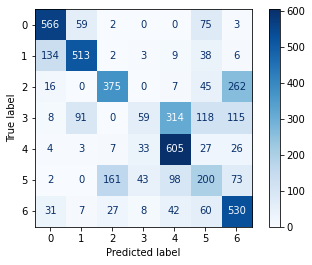

In [ ]:
# 测试
from sklearn import metrics  # 画混淆矩阵
from sklearn.preprocessing import label_binarize  # 二值化类标》多分类化为2分类
from sklearn.metrics import plot_precision_recall_curve  # 画PR曲线

# TEST_DATA_NAME="test set"
# X_TEST_array=x_test
# Y_TEST_array=y_test
# print(f"{TEST_DATA_NAME}: X_TEST shape={X_TEST_array.shape}, Y_TEST shape={Y_TEST_array.shape}")

# test_num= min(10000,X_TEST_array.shape[0])
# y_pred_score_result = model.predict(X_TEST_array[:test_num,])
# print(f"y_pred_result={y_pred_score_result[0,:]}, shape={y_pred_score_result.shape}")
# y_pred_class_result = np.argmax(y_pred_score_result, axis=1)
# assert len(Y_TEST_array.shape)==2 and Y_TEST_array.shape[1]==1,"Y_TEST_array shape error!"
# y_truth_array = np.reshape(Y_TEST_array[:test_num,],(test_num))

# 使用 Datagenerator 方式测试
batch_size=300
# validate_generator = DataGenerator(x_validate,y_validate, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())
validate_generator = DataGenerator(x_test,y_test, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())
y_truth_list =[]
y_pred_score_result = []
for index in range(validate_generator.__len__()):
  x_test_tmp, y = validate_generator.__getitem__(index)
  y_pred_score = model.predict(x_test_tmp)
  y_truth_list.extend(y.tolist())
  y_pred_score_result.extend(y_pred_score.tolist())

y_truth_array = np.array(y_truth_list)
y_truth_array = np.reshape(y_truth_array, (y_truth_array.shape[0]))
y_pred_score_result = np.array(y_pred_score_result)
y_pred_class_result = np.argmax(y_pred_score_result, axis=1)

# 画混淆矩阵
def plot_confusion_matrix(y_pred,y_truth,model_name,class_num=7,cmap='viridis'):
  cm = metrics.confusion_matrix(y_truth,y_pred)
  print(f"Confusion Matrix={cm}")
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.arange(0,class_num,1))
  disp.plot(include_values=True,cmap=cmap, ax=None, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)

plot_confusion_matrix(y_pred_class_result, y_truth_array,model_name,cmap=plt.cm.Blues)

In [ ]:
def Metrics_Accuracy_etc(y_test, y_test_pred,class_num=7):
    # 1.Accuracy
    print("Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
    # 2.Precision
    print("Precision")
    Precision_list = metrics.precision_score(y_test, y_test_pred, average=None)  # average参数=None，多分类时返回每个类的precision
    for i in range(class_num):
        print("class{}'s Precision={}".format(i, Precision_list[i]))
    print("Macro Precision=", metrics.precision_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 3.Recall
    print("Recall")
    Recall_list = metrics.recall_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Recall={}".format(i, Recall_list[i]))
    print("Macro Recall=", metrics.recall_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 4.F1_score
    print("F1-score")
    F1_list = metrics.f1_score(y_test, y_test_pred, average=None)
    for i in range(class_num): 
        print("class{}'s F1-score={}".format(i, F1_list[i]))
    print("Macro F1-score=", metrics.f1_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 5.Jaccard_score 判断相似度
    # 多分类》》视为2分类
    print("Jaccard系数（分析相似度）")
    Jaccard_list = metrics.jaccard_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Jaccard={}".format(i, Jaccard_list[i]))
    print("Macro Jaccard=", metrics.jaccard_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均
    plt.show()
Metrics_Accuracy_etc(y_truth_array,y_pred_class_result)

Accuracy: 0.5924693155814438
Precision
class0's Precision=0.7437582128777924
class1's Precision=0.7622585438335809
class2's Precision=0.6533101045296167
class3's Precision=0.4041095890410959
class4's Precision=0.5627906976744186
class5's Precision=0.3552397868561279
class6's Precision=0.5221674876847291
Macro Precision= 0.5719477746424803
Recall
class0's Recall=0.8028368794326242
class1's Recall=0.7276595744680852
class2's Recall=0.5319148936170213
class3's Recall=0.08368794326241134
class4's Recall=0.8581560283687943
class5's Recall=0.3466204506065858
class6's Recall=0.75177304964539
Macro Recall= 0.5860926884858445
F1-score
class0's F1-score=0.772169167803547
class1's F1-score=0.7445573294629898
class2's F1-score=0.5863956215793588
class3's F1-score=0.13866039952996476
class4's F1-score=0.6797752808988764
class5's F1-score=0.3508771929824562
class6's F1-score=0.6162790697674418
Macro F1-score= 0.5555305802892336
Jaccard系数（分析相似度）
class0's Jaccard=0.6288888888888889
class1's Jaccard=0.

# 4.绘制ROC、PR曲线 

(4807, 7) (4807, 7)
class_no=0:Area under the ROC curve: 0.9529834953369918
class_no=1:Area under the ROC curve: 0.9540386803185438
class_no=2:Area under the ROC curve: 0.9178093370817211
class_no=3:Area under the ROC curve: 0.7094383988436709
class_no=4:Area under the ROC curve: 0.9309504790951308
class_no=5:Area under the ROC curve: 0.7811528202859004
class_no=6:Area under the ROC curve: 0.9076591249381896
(5713,) (5713,) [0.00000000e+00 4.16059913e-04 6.24089869e-04 ... 8.77262326e-01
 8.77262326e-01 1.00000000e+00] [0.         0.03869357 0.05387976 ... 0.99979197 1.         1.        ]
macro roc:Area under the ROC curve: 0.9076591249381896
class_no=0:Area under the PR curve: 0.7568567890786305
class_no=1:Area under the PR curve: 0.8166991185308873
class_no=2:Area under the PR curve: 0.6693699543748091
class_no=3:Area under the PR curve: 0.23097212260534
class_no=4:Area under the PR curve: 0.7232432991112605
class_no=5:Area under the PR curve: 0.3725612457433822
class_no=6:Area unde

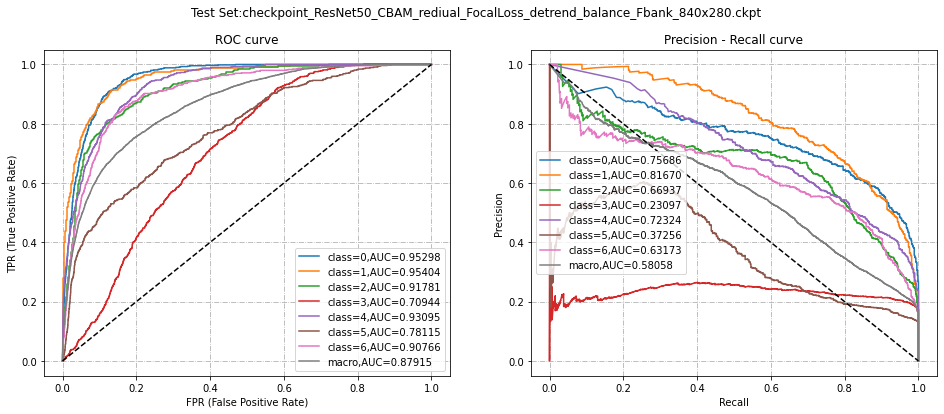

In [ ]:
"""4.2绘制ROC"""
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_multi_calss_ROC_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,1)
  for class_no in range(class_num):
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]
    fpr, tpr, thresholds = metrics.roc_curve((y_true), y_scores)
    AUC_ROC = metrics.roc_auc_score(y_true, y_scores)
    # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
    print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC}")
    plt.plot(fpr,tpr,'-',label=f"class={class_no},AUC={AUC_ROC:.5f}")
  
  # 绘制 macro-roc
  fpr_macro, tpr_macro, thresholds = metrics.roc_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  AUC_ROC_macro = metrics.roc_auc_score(y_true_one_hot, y_pred_scores)
  # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
  print(fpr_macro.shape, tpr_macro.shape, fpr_macro, tpr_macro)
  print (f"macro roc:Area under the ROC curve: {AUC_ROC}")
  plt.plot(fpr_macro,tpr_macro,'-',label=f"macro,AUC={AUC_ROC_macro:.5f}")
  
  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"ROC.png")

def plot_multi_calss_PR_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,2)
  for class_no in range(class_num):
    #Precision-recall curve
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
    recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
    # 加入 （0，1），（1，0）点
    recall = np.append(recall,1)
    precision = np.append(precision,0)
    AUC_prec_rec = np.trapz(precision,recall)
    print (f"class_no={class_no}:Area under the PR curve: {AUC_prec_rec}")
    plt.plot(recall,precision,'-',label=f"class={class_no},AUC={AUC_prec_rec:.5f}")
  
  # 绘制 macro-pr
  precision_macro, recall_macro, thresholds = metrics.precision_recall_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  precision_macro = np.fliplr([precision_macro])[0]  #so the array is increasing (you won't get negative AUC)
  recall_macro = np.fliplr([recall_macro])[0]  #so the array is increasing (you won't get negative AUC)
  # 加入 （0，1），（1，0）点
  recall_macro = np.append(recall_macro,1)
  precision_macro = np.append(precision_macro,0)
  AUC_pr_macro_rec = np.trapz(precision_macro,recall_macro)
  print (f"macro roc:Area under the PR curve: {AUC_pr_macro_rec}")
  plt.plot(recall_macro,precision_macro,'-',label=f"macro,AUC={AUC_pr_macro_rec:.5f}")

  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"Precision_recall.png")


y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result.shape, y_pred_score_result.shape)
plot_multi_calss_ROC_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)
plot_multi_calss_PR_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)

### Comparision: barely macro-ROC, macro-PR curve

[[0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0]]
(5713,) (5713,)
class_no=macro:Area under the ROC curve: 0.8791474765571641
macro roc:Area under the PR curve: 0.5805843058822848
保存 roc-pr 数据成功:save_path=/content/drive/MyDrive/Pulse_7_Classification/model/roc_pr_checkpoint_ResNet50_CBAM_rediual_FocalLoss_detrend_balance_Fbank_840x280.ckpt


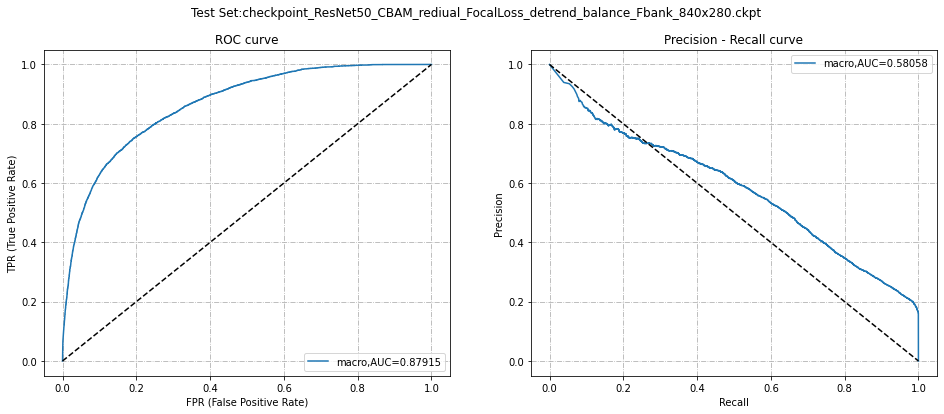

In [ ]:
plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set:{model_name}")
def plot_macro_roc_curve(y_true_one_hot,y_pred_scores):
  class_no='macro'
  fpr_macro, tpr_macro, thresholds = metrics.roc_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  AUC_ROC_macro = metrics.roc_auc_score(y_true_one_hot, y_pred_scores)
  # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
  print(fpr_macro.shape, tpr_macro.shape)
  print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC_macro}")
  plt.subplot(1,2,1)
  plt.plot(fpr_macro,tpr_macro,'-',label=f"macro,AUC={AUC_ROC_macro:.5f}")

  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')

  # 绘制 macro-pr
  plt.subplot(1,2,2)
  precision_macro, recall_macro, thresholds = metrics.precision_recall_curve((y_true_one_hot.ravel()), y_pred_scores.ravel())
  precision_macro = np.fliplr([precision_macro])[0]  #so the array is increasing (you won't get negative AUC)
  recall_macro = np.fliplr([recall_macro])[0]  #so the array is increasing (you won't get negative AUC)
  # 加入 （0，1），（1，0）点
  recall_macro = np.append(recall_macro,1)
  precision_macro = np.append(precision_macro,0)
  AUC_pr_macro_rec = np.trapz(precision_macro,recall_macro)
  print (f"macro roc:Area under the PR curve: {AUC_pr_macro_rec}")
  plt.plot(recall_macro,precision_macro,'-',label=f"macro,AUC={AUC_pr_macro_rec:.5f}")
  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')

  # 保存模型的 macro_fpr, macro_tpr, macro_recall, macro_precision
  save_path = model_save_dir.joinpath(f"roc_pr_{model_name}").as_posix()
  data={"fpr":fpr_macro,"tpr": tpr_macro, "precision":precision_macro, "recall":recall_macro,
        "AUC_roc_macro":AUC_ROC_macro,"AUC_pr_macro":AUC_pr_macro_rec}
  np.savez(save_path,data=data)
  print(f"保存 roc-pr 数据成功:save_path={save_path}")


y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_macro_roc_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)


## 不同模型比较 roc、pr

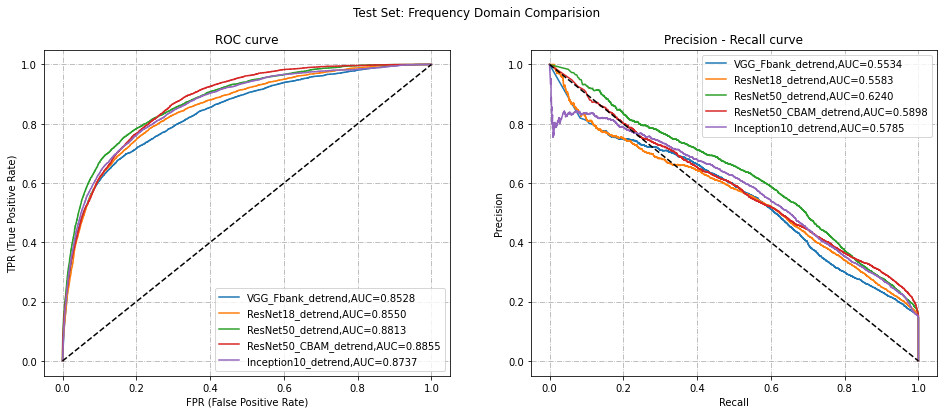

In [ ]:
Inception10_detrend = np.load(model_save_dir.joinpath("roc_pr_Inception-10_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint.npz"), allow_pickle=True)
Inception10_detrend = Inception10_detrend["data"].item()
# VGG16_MFCC_no_detrend = np.load(model_save_dir.joinpath("roc_pr_VGG16_MFCC_130_666.0_840x280_130epoch.npz"), allow_pickle=True)
# VGG16_MFCC_no_detrend = VGG16_MFCC_no_detrend["data"].item()
# VGG_MFCC_detrend = np.load(model_save_dir.joinpath("roc_pr_VGG16_detrend_MFCC_200_666.0_840x280_200epoch_best_checkpoint.npz"), allow_pickle=True)
# VGG_MFCC_detrend = VGG_MFCC_detrend["data"].item()
VGG_Fbank_detrend = np.load(model_save_dir.joinpath("roc_pr_VGG16_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint.npz"), allow_pickle=True)
VGG_Fbank_detrend = VGG_Fbank_detrend["data"].item()
ResNet18_detrend = np.load(model_save_dir.joinpath("roc_pr_ResNet18_detrend_balance_Fbank_11_666.0_840x280_best_checkpoint.npz"), allow_pickle=True)
ResNet18_detrend = ResNet18_detrend["data"].item()
ResNet50_detrend = np.load(model_save_dir.joinpath("roc_pr_ResNet50_detrend_balance_Fbank_40_666.0_840x280_best_checkpoint.npz"), allow_pickle=True)
ResNet50_detrend = ResNet50_detrend["data"].item()
ResNet50_CBAM_detrend = np.load(model_save_dir.joinpath("roc_pr_ResNet50_CBAM_detrend_balance_Fbank_40_666.0_840x280_best_checkpoint.npz"), allow_pickle=True)
ResNet50_CBAM_detrend = ResNet50_CBAM_detrend["data"].item()


plt.figure(figsize=(16,6))
plt.suptitle(f"Test Set: Frequency Domain Comparision")
plt.subplot(1,2,1)
# plt.plot(VGG16_MFCC_no_detrend["fpr"],VGG16_MFCC_no_detrend["tpr"], label=f"VGG16_MFCC_no_detrend,AUC={VGG16_MFCC_no_detrend['AUC_roc_macro']:.4f}")
# plt.plot(VGG_MFCC_detrend["fpr"],VGG_MFCC_detrend["tpr"], label=f"VGG_MFCC_detrend,AUC={VGG_MFCC_detrend['AUC_roc_macro']:.4f}")
plt.plot(VGG_Fbank_detrend["fpr"],VGG_Fbank_detrend["tpr"], label=f"VGG_Fbank_detrend,AUC={VGG_Fbank_detrend['AUC_roc_macro']:.4f}")
plt.plot(ResNet18_detrend["fpr"],ResNet18_detrend["tpr"], label=f"ResNet18_detrend,AUC={ResNet18_detrend['AUC_roc_macro']:.4f}")
plt.plot(ResNet50_detrend["fpr"],ResNet50_detrend["tpr"], label=f"ResNet50_detrend,AUC={ResNet50_detrend['AUC_roc_macro']:.4f}")
plt.plot(ResNet50_CBAM_detrend["fpr"],ResNet50_CBAM_detrend["tpr"], label=f"ResNet50_CBAM_detrend,AUC={ResNet50_CBAM_detrend['AUC_roc_macro']:.4f}")
plt.plot(Inception10_detrend["fpr"],Inception10_detrend["tpr"], label=f"Inception10_detrend,AUC={Inception10_detrend['AUC_roc_macro']:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.grid(which="major", axis='both', linestyle='-.')

plt.subplot(1,2,2)
# plt.plot(VGG16_MFCC_no_detrend["recall"],VGG16_MFCC_no_detrend["precision"], label=f"VGG16_MFCC_no_detrend,AUC={VGG16_MFCC_no_detrend['AUC_pr_macro']:.4f}")
# plt.plot(VGG_MFCC_detrend["recall"],VGG_MFCC_detrend["precision"], label=f"VGG_MFCC_detrend,AUC={VGG_MFCC_detrend['AUC_pr_macro']:.4f}")
plt.plot(VGG_Fbank_detrend["recall"],VGG_Fbank_detrend["precision"], label=f"VGG_Fbank_detrend,AUC={VGG_Fbank_detrend['AUC_pr_macro']:.4f}")
plt.plot(ResNet18_detrend["recall"],ResNet18_detrend["precision"], label=f"ResNet18_detrend,AUC={ResNet18_detrend['AUC_pr_macro']:.4f}")
plt.plot(ResNet50_detrend["recall"],ResNet50_detrend["precision"], label=f"ResNet50_detrend,AUC={ResNet50_detrend['AUC_pr_macro']:.4f}")
plt.plot(ResNet50_CBAM_detrend["recall"],ResNet50_CBAM_detrend["precision"], label=f"ResNet50_CBAM_detrend,AUC={ResNet50_CBAM_detrend['AUC_pr_macro']:.4f}")
plt.plot(Inception10_detrend["recall"],Inception10_detrend["precision"], label=f"Inception10_detrend,AUC={Inception10_detrend['AUC_pr_macro']:.4f}")
plt.plot([0,1],[1,0],'k--')
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid(which="major", axis='both', linestyle='-.')

In [ ]:
model.summary()

## Q：train、validate上能拟合很好，但测试基上效果很差？
- 测试集选取：7类数据，从每类选出5个样本，共35个样本？

In [ ]:
# 查看原始信息
downsampled_npz_filename = "downsampled_train_test_dict.npz"
sample_rate = 666.0  # 统一的采样率
npz_save_path_str = pulse_dataset_dir.joinpath(downsampled_npz_filename).as_posix()
assert Path(npz_save_path_str).is_file(), f"文件不存在, filepath={npz_save_path_str}"
pulse_all_class_data_dict = pulse_preprocess.load_npy_saved_pulse_data(npz_save_path=npz_save_path_str)

In [ ]:
# 原始脉诊样本
class_data_info_dict={class_no:(len(pulse_all_class_data_dict[class_no]["train"]),len(pulse_all_class_data_dict[class_no]["test"])) for class_no in pulse_all_class_data_dict}
print(class_data_info_dict)

# train、test、validate 中的各类分布
train_distribution_dict={class_no:np.sum(y_train==class_no) for class_no in class_data_info_dict}
print(f"x_train distribution:{train_distribution_dict}")

{2: (54, 5), 1: (39, 5), 5: (188, 5), 6: (435, 5), 0: (92, 5), 4: (117, 5), 3: (28, 5)}
x_train distribution:{2: 14660, 1: 14523, 5: 24716, 6: 39882, 0: 11820, 4: 16369, 3: 11816}


In [ ]:
# 查看原始 class 3 曲线
import math
def show_single_class_wave(pulse_all_class_data_dict, class_no):
  assert class_no in pulse_all_class_data_dict, "class_no error!"
  wave_data_list =[item["data"] for item in pulse_all_class_data_dict[class_no]["train"]]
  wave_data_list.extend([item["data"] for item in pulse_all_class_data_dict[class_no]["test"]])
  data_num = len(wave_data_list)
  wave_data_list = wave_data_list[:33] if len(wave_data_list)>33 else wave_data_list
  columns_num = 3
  rows_num = int(len(wave_data_list)//columns_num)+1
  plt.figure(figsize=(3*5, (len(wave_data_list)//3)*5))   
  for i in range(len(wave_data_list)):
    plt.subplot(rows_num,3, i+1)
    plt.plot(wave_data_list[i][0,:2400])
  plt.suptitle(f"class_no={class_no} Num={data_num}")
  plt.show()

show_single_class_wave(pulse_all_class_data_dict,class_no=3)




In [ ]:
!pip install biosppy

In [ ]:
# 去基线漂移
from scipy.signal import butter, filtfilt, medfilt
from biosppy.signals import ecg
import time

def detrend_wave_data(wave_data_array, sample_rate=666):
    """去除基线漂移: 基线漂移是一种低频噪声成分, 频率通常小于1Hz, 使用巴特沃斯高通过滤"""
    assert len(wave_data_array.shape) == 2
    print(f"wave_data_array shape={wave_data_array.shape}")
    start_time = time.time()

    
    LOW_CUT = 0.5
    HIGH_CUT = 49
    fn = 0.5 * sample_rate  # 最大频率
    f_low = LOW_CUT / fn
    f_high = HIGH_CUT / fn

    # 1. 0.5-100Hz 四阶巴特沃斯带通过滤器
    method_name=f"{LOW_CUT}Hz-{HIGH_CUT}Hz bandpass"
    freq_window = [f_low, f_high]
    b, a = butter(N=4, Wn=freq_window, btype="bandpass")
    filtered_signal = filtfilt(b, a, wave_data_array)
    print(f"filtered_signal.shape={filtered_signal.shape}， filtered_signal={filtered_signal}")

    plt.figure(figsize=(20,10))
    plt.subplot(2, 1, 1)
    plt.plot(wave_data_array[0, :8000], 'r-', label=f"origin data")
    plt.subplot(2, 1, 2)
    plt.plot(filtered_signal[0, :8000], 'b-', label=f"detrend data")
    plt.suptitle(method_name)

    plt.show()

class_no, data_index = 3,-4
test_wave_data = pulse_all_class_data_dict[class_no]["test"][data_index]["data"]
detrend_wave_data(test_wave_data)

In [ ]:
# 获取波峰
from biosppy.signals import ecg

def get_wave_peak_bottom(wave_data_array, current_sample_rate=666):
  assert len(wave_data_array.shape)==2,f"shape not match"
  peak_result = ecg.christov_segmenter(wave_data_array[0,], sampling_rate=current_sample_rate)
  rpeaks_result = peak_result['rpeaks']
  # get bottom
  peak_result = ecg.christov_segmenter(wave_data_array[0,]*(-1),sampling_rate=current_sample_rate)
  bottom_result = peak_result['rpeaks']
  return rpeaks_result, bottom_result
rpeaks_result, bottom_result = get_wave_peak_bottom(test_wave_data[:,:1000])
print(rpeaks_result, bottom_result)
plt.figure(figsize=(30,5))
plt.plot(test_wave_data[0,:1000],'b-')
plt.plot(rpeaks_result, test_wave_data[0,rpeaks_result],'r*')
plt.plot(bottom_result, test_wave_data[0,bottom_result],'ro')
plt.suptitle(f"Peak Num={len(rpeaks_result)}")
plt.show()

In [ ]:
bottom_result = np.array(bottom_result)
bottom_distance_list = bottom_result[1:]-bottom_result[0:-1]
print(bottom_distance_list, np.sum(bottom_distance_list)/bottom_distance_list.shape[0])

[494 515 535 503 523 539 531 503 517 522 495 488 488 509 499 485 498 507
 510 501 498 524 522 504 507 508 513 492 500 510 502 479 481 485 495 485
 473 487 497 496 470 484 490 523 497 503 515 500 478 510 514 498 487 515
 509 493 507 521 508 484 523 535 522 512 521 516 497 473 471 487 462 455
 477 488 474 469 480 490 462] 499.24050632911394


---
## 对完整样本给出预测结果

In [ ]:
pulse_preprocess = PulsePreprocessing()
pulse_feature = PulseFeature()

# 降采样数据
downsampled_npz_filename = "downsampled_train_test_dict.npz"
sample_rate = 666.0  # 统一的采样率
npz_save_path_str = pulse_dataset_dir.joinpath(downsampled_npz_filename).as_posix()
assert Path(npz_save_path_str).is_file(), f"文件不存在, filepath={npz_save_path_str}"
pulse_all_class_data_dict = pulse_preprocess.load_npy_saved_pulse_data(npz_save_path=npz_save_path_str)

# 去基线漂移+去噪
start_time = time.time()
pulse_all_class_data_dict = pulse_preprocess.detrend_wave_data(pulse_all_class_data_dict)
print(f"去噪+去基线漂移完成！costs={time.time() - start_time}s")

# # 1.测试数据: 取出完整样本预测
# x_test = []
# y_test = []
# for class_no in pulse_all_class_data_dict:
#     data_type = "test"
#     for data_info_dict in pulse_all_class_data_dict[class_no][data_type]:
#         x_test.append(data_info_dict["data"][0, :])
#         y_test.append(class_no)
# x_test_list = x_test  # 长度可能不一致！
# y_test = np.array([y_test]).T

# 2.切片
start_time = time.time()
heart_beat_average_seconds = 1.2 # 按平均一次心跳的秒数分片
frame_length = math.ceil(heart_beat_average_seconds * sample_rate)*3  # 2400
frame_step = 350  # int(frame_length/3)
x_train, y_train, x_test, y_test = PulsePreprocessing.get_train_test_data_slice(
    pulse_all_class_data_dict,frame_length=frame_length,frame_step=frame_step)
print(f"get data slices costs={time.time() - start_time}s")  # 9s

class_no=2 去基线漂移完成！
class_no=1 去基线漂移完成！
class_no=5 去基线漂移完成！
class_no=6 去基线漂移完成！
class_no=0 去基线漂移完成！
class_no=4 去基线漂移完成！
class_no=3 去基线漂移完成！
去噪+去基线漂移完成！costs=1.3429133892059326s
class_no=2, data_type_str=train 分片完成！
class_no=2, data_type_str=test 分片完成！
class_no=1, data_type_str=train 分片完成！
class_no=1, data_type_str=test 分片完成！
class_no=5, data_type_str=train 分片完成！
class_no=5, data_type_str=test 分片完成！
class_no=6, data_type_str=train 分片完成！
class_no=6, data_type_str=test 分片完成！
class_no=0, data_type_str=train 分片完成！
class_no=0, data_type_str=test 分片完成！
class_no=4, data_type_str=train 分片完成！
class_no=4, data_type_str=test 分片完成！
class_no=3, data_type_str=train 分片完成！
class_no=3, data_type_str=test 分片完成！
x_train shape=(108128, 2400)
y_train shape=(108128, 1)
x_test shape=(3712, 2400)
y_test shape=(3712, 1)
get data slices costs=31.948880910873413s


In [ ]:
print(f"x_test_list len={len(x_test_list)} y_test shape={y_test.shape}")
print(f"x_test[0] shape={x_test_list[0].shape}")

# 查看测试集合各类分布
train_distribution_dict={class_no:np.sum(y_test==class_no) for class_no in pulse_all_class_data_dict}
print(f"y_test distribution:{train_distribution_dict}")

### Two-stream model

In [ ]:
def two_stream_classifier(time_model, freq_model):
    time_model_input = Input(shape=(40, 60), name="time_model_input")  # 1x2400 -> 40x60
    freq_model_input = Input(shape=(None, None, 1), name="freq_model_input")  # MFCC 119x60x1
    time_result = time_model(time_model_input)
    freq_result = freq_model(freq_model_input)

    two_stream_result = Average()([time_result, freq_result])  # two-stream late fusion  Maximum
    # two_stream_result = freq_result  # frequency only
    # two_stream_result = time_result

    network = Model(inputs=[time_model_input, freq_model_input], outputs=two_stream_result, name="two_stream_PulseNet")
    return network


class TwoStreamPredict:
    def __init__(self, pulse_feature_instance: PulseFeature, freq_model: Model, time_model: Model,
                 feature_sample_rate=666, freq_frame_info=(840, 280), time_frame_info=(2400, 350, 40),
                 uniform_sample_num=10, freq_feature_choice="MFCC"):
        self.pulse_feature = pulse_feature_instance
        self.sample_rate = feature_sample_rate
        self.uniform_sample_num = uniform_sample_num
        assert freq_feature_choice in ["MFCC", "Fbank"], f"freq_feature_choice={freq_feature_choice} ERROR!"
        self.freq_feature_choice = True if freq_feature_choice == "MFCC" else False  # True->MFCC, False->Fbank

        # 分片信息
        self.freq_frame_length = freq_frame_info[0]  # 频域模型使用的分片大小
        self.freq_frame_step = freq_frame_info[1]
        self.time_frame_length = time_frame_info[0]
        self.time_frame_step = time_frame_info[1]
        self.RNN_time_step = time_frame_info[2]
        assert self.time_frame_length % self.RNN_time_step == 0, f"RNN input shape error!"
        self.RNN_feature_num_each_input = int(self.time_frame_length / self.RNN_time_step)

        self.freq_model = freq_model
        self.time_model = time_model
        self.two_stream_model = two_stream_classifier(time_model=self.time_model, freq_model=self.freq_model)

    @staticmethod
    def get_data_slice(wave_data_array, frame_length, frame_step):
        assert isinstance(wave_data_array, np.ndarray) and len(wave_data_array.shape) == 1, f"wave data shape error!"

        signal_length = len(wave_data_array)
        num_frames = int(
            np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1
        pad_signal_length = (num_frames - 1) * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        # 分帧后最后一帧点数不足，则补零
        # 获取帧：frames 是二维数组，每一行是一帧，列数是每帧的采样点数，之后的短时 fft 直接在每一列上操作
        pad_signal = np.append(wave_data_array, z)
        indices = np.arange(0, frame_length).reshape(
            1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
        frames = pad_signal[indices]
        return frames

    def batch_sample_predict(self, x_test_list: List[np.ndarray], numcep_mfcc=20) -> np.ndarray:
        """
        对每个原始样本预测
        :param x_test_list: 原始波形样本，长度可能不一致！
        :param numcep_mfcc:
        :return: y_sample_predict_score_result
        """
        assert len(x_test_list[0].shape) == 1, f"x_test_list element_array shape error!"
        y_sample_predict_result = []
        for index in range(len(x_test_list)):
            x_data = x_test_list[index]
            print(f"x_data shape={x_data.shape}")
            # 0. 时域分片 1x2400
            x_data_frames = self.get_data_slice(wave_data_array=x_data,
                                                frame_length=self.time_frame_length, frame_step=self.time_frame_step)

            # 均匀取 n 帧 进行预测
            select_index_array = np.linspace(0, x_data_frames.shape[0], self.uniform_sample_num,
                                             endpoint=False, dtype=int)
            select_slice_array = x_data_frames[select_index_array, :]
            # print(f"select_index_array={select_index_array}, select_slice_array shape={select_slice_array.shape}")

            # 1. 频域时域输入特征转化
            # 时域
            time_data_array = np.reshape(select_slice_array, (select_slice_array.shape[0],
                                                              self.RNN_time_step, self.RNN_feature_num_each_input))
            # 频域
            freq_data_array = []
            for wave_data in select_slice_array:
                wave_data = np.reshape(wave_data[:self.freq_frame_length], (1, self.freq_frame_length))
                if self.freq_feature_choice:
                    freq_feature_matrix = self.pulse_feature.get_dynamic_mfcc_matrix(wave_data=wave_data,
                                                                                     sample_rate=self.sample_rate,
                                                                                     numcep=numcep_mfcc)
                else:
                    freq_feature_matrix = self.pulse_feature.get_fbank_matrix(wave_data=wave_data,
                                                                              sample_rate=sample_rate)
                freq_data_array.append(freq_feature_matrix)
            freq_data_array = np.array(freq_data_array)
            freq_data_array = np.reshape(freq_data_array, (*freq_data_array.shape, 1))
            print(f"freq_data_array.shape={freq_data_array.shape}")

            # 2. 对每个分片预测
            # # 0. 单独调用方式
            # freq_predict_scores = self.freq_model.predict(freq_data_array)
            # time_predict_scores = self.time_model.predict(time_data_array)
            # y_slices_predict_scores = (freq_predict_scores + time_predict_scores) / 2

            # 1. 模型融合
            y_slices_predict_scores = self.two_stream_model.predict([time_data_array, freq_data_array])

            y_sample_predict_scores = np.average(y_slices_predict_scores, axis=0)
            y_sample_predict_result.append(y_sample_predict_scores)
            print(
                f"index={index} y_sample_predict_scores={y_sample_predict_scores} shape={y_sample_predict_scores.shape}")
            # break

        return np.array(y_sample_predict_result)

    def predict_time_slice_2_stream(self, x_test_array: np.ndarray, numcep_mfcc=20) -> np.ndarray:
        """
        直接取分片好的 1x2400 大小分片数据，进行预测
        :param x_test_array: Nx2400
        :param numcep_mfcc:
        :return: y_sample_predict_scores -> Nx7
        """
        assert isinstance(x_test_array, np.ndarray) and len(x_test_array.shape) == 2, "x_test shape not match!"

        # 1. 频域时域输入特征转化
        # 时域
        time_data_array = np.reshape(x_test_array, (x_test_array.shape[0],
                                                    self.RNN_time_step, self.RNN_feature_num_each_input))
        # 频域
        freq_data_array = []
        for index in range(x_test_array.shape[0]):
            wave_data = x_test_array[index, :self.freq_frame_length]
            wave_data = np.reshape(wave_data, (1, -1))
            if self.freq_feature_choice:
                freq_feature_matrix = self.pulse_feature.get_dynamic_mfcc_matrix(wave_data=wave_data,
                                                                                 sample_rate=self.sample_rate,
                                                                                 numcep=numcep_mfcc)
            else:
                freq_feature_matrix = self.pulse_feature.get_fbank_matrix(wave_data=wave_data,
                                                                          sample_rate=sample_rate)
            freq_data_array.append(freq_feature_matrix)
        freq_data_array = np.array(freq_data_array)
        freq_data_array = np.reshape(freq_data_array, (*freq_data_array.shape, 1))
        print(f"freq_data_array.shape={freq_data_array.shape}")

        # two-stream model predict
        y_sample_predict_scores = self.two_stream_model.predict([time_data_array, freq_data_array])
        print(f"y_sample_predict_scores={y_sample_predict_scores} shape={y_sample_predict_scores.shape}")

        return y_sample_predict_scores

In [ ]:
# 对每个样本预测
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import concatenate, Add, Average, Maximum

model_save_dir=base_path.joinpath("model")
model_save_dir.mkdir(exist_ok=True, parents=True)

# 0. 加载模型
time_model_name = "BiLSTM-2layer_detrend_balance_TimeDomain_100_666.0_2400x350_best_checkpoint"
# freq_model_name = "VGG16_detrend_balance_MFCC_numcep20_666.0_840x280_best_checkpoint"  # "VGG16_detrend_MFCC_200_666.0_840x280_200epoch_best_checkpoint"
freq_model_name = "VGG16_detrend_balance_Fbank_120_666.0_840x280_best_checkpoint"

time_model_path = model_save_dir.joinpath(time_model_name)
freq_model_path = model_save_dir.joinpath(freq_model_name)
assert time_model_path.exists() and freq_model_path.exists(), f"model file not exists"
time_domain_model = load_model(time_model_path)
freq_domain_model = load_model(freq_model_path)

# 1. 分片信息
_time_frame_info = (2400, 350, 40)  # frame_length, frame_step, RNN time step
_freq_frame_info = (840, 280)
numcep_mfcc = 20
freq_feature_choice_str = "Fbank"
assert _time_frame_info[0] % _time_frame_info[2] == 0, f"RNN input shape error!"
two_stream_predict = TwoStreamPredict(pulse_feature_instance=pulse_feature,
                                      freq_model=freq_domain_model, time_model=time_domain_model,
                                      feature_sample_rate=666, freq_frame_info=_freq_frame_info,
                                      time_frame_info=_time_frame_info,
                                      uniform_sample_num=10, freq_feature_choice=freq_feature_choice_str)
# y_pred_score_result = two_stream_predict.batch_sample_predict(x_test_list=x_test_list,numcep_mfcc=numcep_mfcc)
# 以分片为单位预测
y_pred_score_result = two_stream_predict.predict_time_slice_2_stream(x_test_array=x_test,numcep_mfcc=numcep_mfcc)

freq_data_array.shape=(3712, 119, 200, 1)
y_sample_predict_scores=[[4.1626862e-09 2.4538365e-09 2.5976387e-06 ... 4.6515644e-05
  2.6194873e-05 9.9992460e-01]
 [2.6720190e-06 1.8074223e-05 1.6506677e-04 ... 3.7235632e-03
  1.5601830e-03 9.9445498e-01]
 [2.6633063e-07 4.7907442e-09 1.7014589e-06 ... 3.4073109e-04
  2.1217183e-04 9.9944484e-01]
 ...
 [2.3931326e-10 3.6471726e-09 6.8875039e-09 ... 5.8669841e-01
  5.8449364e-06 4.1329575e-01]
 [6.4803882e-09 3.8966149e-08 1.2612746e-07 ... 9.5094436e-01
  1.2725771e-04 4.8920233e-02]
 [1.7568247e-07 1.1371953e-07 2.0946058e-05 ... 4.8051938e-01
  1.3345592e-04 5.1925302e-01]] shape=(3712, 7)


test set: Y_TEST shape=(3712, 1)
y_pred_result=[4.1626862e-09 2.4538365e-09 2.5976387e-06 6.5168500e-08 4.6515644e-05
 2.6194873e-05 9.9992460e-01], shape=(3712, 7)
Confusion Matrix=[[478   1   3   2   0  32  29]
 [ 76 422   0  12  13  20   2]
 [  1   0 209   2   3  36 294]
 [  4  44   0  78 358  26  35]
 [  0   0   0  50 471  20   4]
 [  0   0  71  15 116 212  28]
 [ 51   7   9   4  74  43 357]]


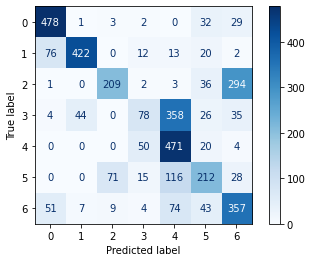

In [ ]:
# 测试
from sklearn import metrics  # 画混淆矩阵
from sklearn.preprocessing import label_binarize  # 二值化类标》多分类化为2分类
from sklearn.metrics import plot_precision_recall_curve  # 画PR曲线
model_name = f"Two-stream_{freq_feature_choice_str}&Time"
TEST_DATA_NAME="test set"
Y_TEST_array=y_test
print(f"{TEST_DATA_NAME}: Y_TEST shape={Y_TEST_array.shape}")
print(f"y_pred_result={y_pred_score_result[0,:]}, shape={y_pred_score_result.shape}")

y_pred_class_result = np.argmax(y_pred_score_result, axis=1)
assert len(Y_TEST_array.shape)==2 and Y_TEST_array.shape[1]==1,"Y_TEST_array shape error!"
y_truth_array = np.reshape(Y_TEST_array[:,],(Y_TEST_array.shape[0]))

# 画混淆矩阵
def plot_confusion_matrix(y_pred,y_truth,model_name,class_num=7,cmap='viridis'):
  cm = metrics.confusion_matrix(y_truth,y_pred)
  print(f"Confusion Matrix={cm}")
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.arange(0,class_num,1))
  disp.plot(include_values=True,cmap=cmap, ax=None, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)

plot_confusion_matrix(y_pred_class_result, y_truth_array,model_name,cmap=plt.cm.Blues)

In [ ]:
def Metrics_Accuracy_etc(y_test, y_test_pred,class_num=7):
    # 1.Accuracy
    print("Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
    # 2.Precision
    print("Precision")
    Precision_list = metrics.precision_score(y_test, y_test_pred, average=None)  # average参数=None，多分类时返回每个类的precision
    for i in range(class_num):
        print("class{}'s Precision={}".format(i, Precision_list[i]))
    print("Macro Precision=", metrics.precision_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 3.Recall
    print("Recall")
    Recall_list = metrics.recall_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Recall={}".format(i, Recall_list[i]))
    print("Macro Recall=", metrics.recall_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 4.F1_score
    print("F1-score")
    F1_list = metrics.f1_score(y_test, y_test_pred, average=None)
    for i in range(class_num): 
        print("class{}'s F1-score={}".format(i, F1_list[i]))
    print("Macro F1-score=", metrics.f1_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均

    # 5.Jaccard_score 判断相似度
    # 多分类》》视为2分类
    print("Jaccard系数（分析相似度）")
    Jaccard_list = metrics.jaccard_score(y_test, y_test_pred, average=None)
    for i in range(class_num):  
        print("class{}'s Jaccard={}".format(i, Jaccard_list[i]))
    print("Macro Jaccard=", metrics.jaccard_score(y_test, y_test_pred, average='macro'))  # 宏Precision 取平均
    plt.show()
Metrics_Accuracy_etc(y_truth_array,y_pred_class_result)

Accuracy: 0.5999461206896551
Precision
class0's Precision=0.7836065573770492
class1's Precision=0.890295358649789
class2's Precision=0.7157534246575342
class3's Precision=0.4785276073619632
class4's Precision=0.45507246376811594
class5's Precision=0.5449871465295629
class6's Precision=0.4766355140186916
Macro Precision= 0.6206968674803867
Recall
class0's Recall=0.8770642201834863
class1's Recall=0.7743119266055046
class2's Recall=0.3834862385321101
class3's Recall=0.14311926605504588
class4's Recall=0.8642201834862385
class5's Recall=0.4796380090497738
class6's Recall=0.655045871559633
Macro Recall= 0.5966979593531132
F1-score
class0's F1-score=0.8277056277056276
class1's F1-score=0.8282630029440627
class2's F1-score=0.49940262843488653
class3's F1-score=0.22033898305084745
class4's F1-score=0.5962025316455696
class5's F1-score=0.5102286401925391
class6's F1-score=0.5517774343122103
Macro F1-score= 0.5762741211836777
Jaccard系数（分析相似度）
class0's Jaccard=0.7060561299852289
class1's Jaccard

[[0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]]
class_no=0:Area under the ROC curve: 0.9799315185557484
class_no=1:Area under the ROC curve: 0.9829398933381227
class_no=2:Area under the ROC curve: 0.9170534439156092
class_no=3:Area under the ROC curve: 0.6584450308948648
class_no=4:Area under the ROC curve: 0.9240336845276548
class_no=5:Area under the ROC curve: 0.8226555689318775
class_no=6:Area under the ROC curve: 0.8607225313800866
class_no=0:Area under the PR curve: 0.8805694909751256
class_no=1:Area under the PR curve: 0.9304012420753404
class_no=2:Area under the PR curve: 0.6906796705682571
class_no=3:Area under the PR curve: 0.2623295447763139
class_no=4:Area under the PR curve: 0.6596970805529616
class_no=5:Area under the PR curve: 0.5772851508021246
class_no=6:Area under the PR curve: 0.44470930433228406


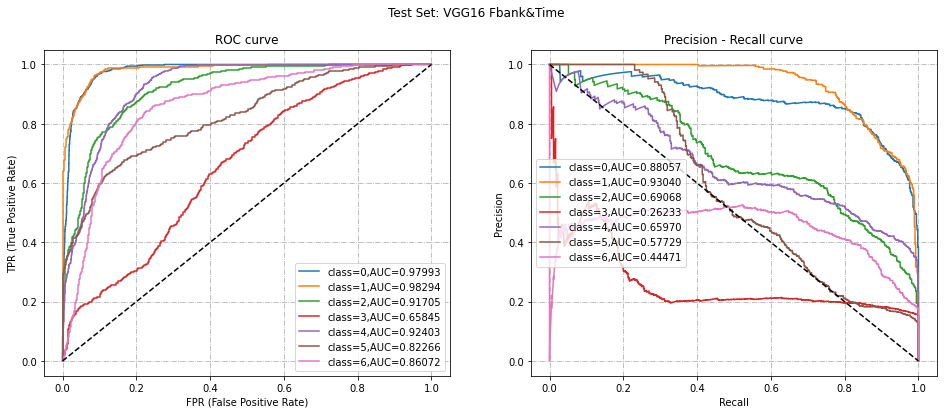

In [ ]:
"""4.2绘制ROC"""
plt.figure(figsize=(16,6))
# plt.suptitle(f"Test Set:{model_name}")
plt.suptitle(f"Test Set: VGG16 Fbank&Time")
def plot_multi_calss_ROC_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,1)
  for class_no in range(class_num):
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]
    fpr, tpr, thresholds = metrics.roc_curve((y_true), y_scores)
    AUC_ROC = metrics.roc_auc_score(y_true, y_scores)
    # test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
    print (f"class_no={class_no}:Area under the ROC curve: {AUC_ROC}")
    plt.plot(fpr,tpr,'-',label=f"class={class_no},AUC={AUC_ROC:.5f}")
  
  plt.plot([0,1],[0,1],'k--')
  plt.title('ROC curve')
  plt.xlabel("FPR (False Positive Rate)")
  plt.ylabel("TPR (True Positive Rate)")
  plt.legend(loc="lower right")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"ROC.png")

def plot_multi_calss_PR_curve(y_true_one_hot,y_pred_scores,class_num=7):
  # plt.figure(figsize=(8,6))
  plt.subplot(1,2,2)
  for class_no in range(class_num):
    #Precision-recall curve
    y_true=y_true_one_hot[:,class_no]
    y_scores=y_pred_scores[:,class_no]

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
    recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
    # 加入 （0，1），（1，0）点
    recall = np.append(recall,1)
    precision = np.append(precision,0)
    AUC_prec_rec = np.trapz(precision,recall)
    print (f"class_no={class_no}:Area under the PR curve: {AUC_prec_rec}")
    plt.plot(recall,precision,'-',label=f"class={class_no},AUC={AUC_prec_rec:.5f}")

  plt.plot([0,1],[1,0],'k--')
  plt.title('Precision - Recall curve')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="best")
  plt.grid(which="major", axis='both', linestyle='-.')
#     plt.savefig(path_experiment+"Precision_recall.png")



y_truth_one_hot_result = np.array(tf.one_hot(y_truth_array, depth=7),dtype=int)
print(y_truth_one_hot_result[:3,])
plot_multi_calss_ROC_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)
plot_multi_calss_PR_curve(y_true_one_hot=y_truth_one_hot_result,y_pred_scores=y_pred_score_result)


## Grad-CAM show attention effect

In [ ]:
model.summary()

for layer_i in model.layers:
  print(type(layer_i),layer_i._name)


slected_layer_name = "block4"
selected_layer = model.get_layer(slected_layer_name)
print(type(selected_layer), selected_layer._name, selected_layer.outputs)
print(selected_layer.inputs)
for sub_layer in selected_layer.layers:
  print(type(sub_layer),sub_layer.output)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 119, 200, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 60, 100, 64)       3136      
                                                                 
 conv1/BatchNorm (BatchNorma  (None, 60, 100, 64)      256       
 lization)                                                       
                                                                 
 re_lu (ReLU)                (None, 60, 100, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 50, 64)       0         
 )                                                               
                                                                 
 block1 (Sequential)         (None, 30, 50, 256)       244313

### 取出部分训练数据

In [ ]:
batch_size = 300
validate_generator = DataGenerator(x_validate,y_validate, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())
# validate_generator = DataGenerator(x_test,y_test, batch_size=batch_size,feature_save_dir_path=fbank_save_dir.as_posix())
for index in range(validate_generator.__len__()):
  x_batch, y_batch = validate_generator.__getitem__(index)
  print(type(x_batch), x_batch.shape, y_batch.shape)
  break

<class 'numpy.ndarray'> (300, 119, 200, 1) (300, 1)


In [ ]:
def make_gradcam_heatmap_ResNet_tmp(img_array, model_show_cam, first_layer_after_conv_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    selected_conv_layer_output = model_show_cam.get_layer(first_layer_after_conv_name).input
    grad_model = tf.keras.models.Model(
        [model_show_cam.inputs], [selected_conv_layer_output, model_show_cam.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print(type(grads), grads.shape)
    print(last_conv_layer_output.shape, preds.shape)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
print(y_batch.T)

[[5 5 0 6 5 6 2 4 0 0 6 3 0 3 0 4 4 1 5 2 3 6 1 5 5 2 4 0 2 1 3 4 4 0 4 0
  5 5 5 1 5 2 3 0 2 1 4 4 0 2 4 0 2 2 3 3 0 5 0 6 1 2 5 0 3 6 2 4 3 4 5 0
  4 5 6 5 2 3 6 6 2 3 5 5 0 6 2 0 1 6 1 5 0 4 3 3 5 3 5 2 2 6 1 1 2 2 2 2
  5 5 1 4 1 1 2 1 0 1 6 4 4 2 3 2 2 0 0 0 1 3 6 2 1 2 6 4 6 3 0 3 4 1 3 5
  1 3 0 5 6 1 1 3 1 0 5 5 6 3 6 5 2 0 5 1 0 4 1 0 6 6 3 2 4 0 4 2 6 2 2 5
  5 6 0 6 6 0 1 2 3 2 3 4 3 1 5 6 1 6 2 0 6 4 6 2 6 0 3 3 5 2 5 6 1 4 3 3
  0 2 4 2 5 2 0 3 0 1 1 3 6 1 3 5 1 6 3 5 0 3 0 5 6 3 3 6 5 2 6 0 0 5 0 5
  0 6 6 6 1 4 5 1 0 6 3 3 0 2 5 5 4 3 6 5 1 2 6 2 0 1 1 2 4 3 6 6 5 2 3 1
  1 6 5 4 5 4 1 3 2 2 2 6]]


show Grad-CAM show_sample_x shape=(1, 119, 200, 1), y_batch[0]=[[4]]
<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 4, 7, 2048)
(1, 4, 7, 2048) (1, 7)
<class 'numpy.ndarray'> (4, 7)


<Figure size 432x288 with 0 Axes>

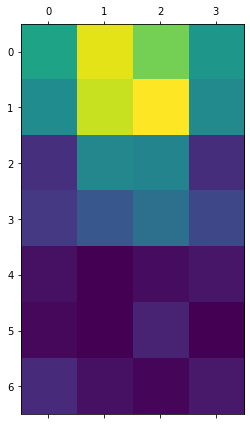

[[0.58030856 0.4874287  0.14015453 0.16702993 0.04566878 0.02077987
  0.11856405]
 [0.96037006 0.91674674 0.4627097  0.27312943 0.         0.
  0.04369666]
 [0.7891537  1.         0.45246086 0.37044534 0.03200211 0.09589314
  0.01926554]
 [0.5280502  0.47893238 0.12981237 0.2170199  0.0603527  0.
  0.06688715]]


In [ ]:
# Generate class activation heatmap
sample_index = 7
show_sample_x = x_batch[sample_index:sample_index+1,:]
show_sample_y = y_batch[sample_index:sample_index+1,:]
print(f"show Grad-CAM show_sample_x shape={show_sample_x.shape}, y_batch[0]={show_sample_y}")
slected_layer_name = "block4"

# 获取中间层输出：构建一个新的模型
model_show_cam = model
slected_layer_name = "global_average_pooling2d"
# grad_model = Model(inputs=model.input, outputs=[model.output, model.get_layer(slected_layer_name).input])

heatmap = make_gradcam_heatmap_ResNet_tmp(show_sample_x, model_show_cam=model, first_layer_after_conv_name=slected_layer_name)
print(type(heatmap), heatmap.shape)

plt.figure()
plt.matshow(heatmap.T)
plt.show()
print(heatmap)

### 和输入图像放一起看

-20.905721566996096 2.190590689883703
0.0 1.0


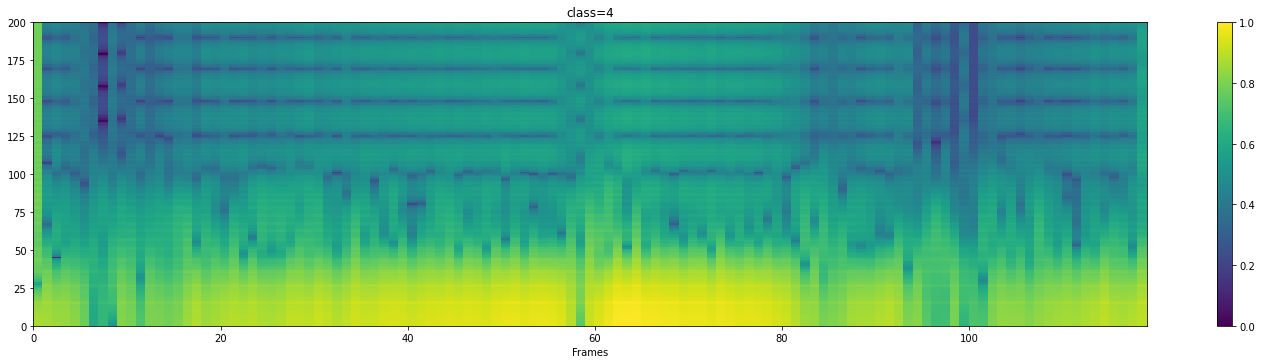

In [ ]:
def plot_spectrogram(spec, save_path=""):
    fig = plt.figure(figsize=(20, 5))
    heatmap = plt.pcolor(spec)
    fig.colorbar(mappable=heatmap)
    plt.xlabel('Frames')
    # tight_layout 会自动调整子图参数，使之填充整个图像区域
    plt.tight_layout()
    # plt.title(save_path.stem)
    plt.title(save_path)
    # plt.savefig(save_path)
    plt.show()

# 归一化到 0-1
fbank_show_data = show_sample_x[0,:,:,0].T
print(np.min(fbank_show_data), np.max(fbank_show_data))
fbank_show_data = (fbank_show_data-np.min(fbank_show_data))/(np.max(fbank_show_data)-np.min(fbank_show_data))
print(np.min(fbank_show_data), np.max(fbank_show_data))
plot_spectrogram(fbank_show_data, save_path=f"class={show_sample_y[0][0]}")

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)